# Order Delivery Time Prediction

**Author** - Sagnik Saha

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
porter_data = pd.read_csv('porter_data_1.csv')
porter_data.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

In [4]:
porter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [5]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
porter_data['created_at'] = pd.to_datetime(porter_data['created_at'])
porter_data['actual_delivery_time'] = pd.to_datetime(porter_data['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [6]:
# Convert categorical features to category type
porter_data['market_id'] = porter_data['market_id'].astype('category').cat.codes
porter_data['store_primary_category'] = porter_data['store_primary_category'].astype('category').cat.codes
porter_data['order_protocol'] = porter_data['order_protocol'].astype('category').cat.codes

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [7]:
# Calculate time taken in minutes
porter_data['time_taken'] = (porter_data['actual_delivery_time'] - porter_data['created_at']).dt.total_seconds() / 60.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [8]:
# Extract the hour and day of week from the 'created_at' timestamp
porter_data['hour'] = porter_data['created_at'].dt.hour
porter_data['day_of_week'] = porter_data['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
porter_data['isWeekend'] = (porter_data['day_of_week'] >= 5).astype(int)

In [9]:
# Drop unnecessary columns
porter_data.drop(['actual_delivery_time','created_at','day_of_week'], axis=1, inplace=True)
porter_data.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken', 'hour',
       'isWeekend'],
      dtype='object')

In [10]:
# porter_data = pd.concat([porter_data, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
porter_data = porter_data.astype("float32")
porter_data.head()

market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        0.0                     4.0             0.0          4.0    3441.0   
1        1.0                    46.0             1.0          1.0    1900.0   
2        1.0                    36.0             2.0          4.0    4771.0   
3        0.0                    38.0             0.0          1.0    1525.0   
4        0.0                    38.0             0.0          2.0    3620.0   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                 4.0           557.0          1239.0                   33.0   
1                 1.0          1400.0          1400.0                    1.0   
2                 3.0           820.0          1604.0                    8.0   
3                 1.0          1525.0          1525.0                    5.0   
4                 2.0          1425.0          2195.0                    5.0   

   total_busy_dashers  total_outstanding_orders   distance  time_taken  hour  \
0                14.0                      21.0  34.439999        47.0  22.0   
1                 2.0                       2.0  27.600000        44.0  21.0   
2                 6.0                      18.0  11.560000        55.0   0.0   
3                 6.0                       8.0  31.799999        59.0   3.0   
4                 5.0                       7.0   8.200000        46.0   2.0   

   isWeekend  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [11]:
# Define target variable (y) and features (X)
y = ['time_taken']
X = ['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'hour',
       'isWeekend']

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [12]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
porter_data_train, porter_data_test = train_test_split(porter_data, train_size=0.8, test_size=0.2, random_state=42)
print(porter_data_train.shape)
print(porter_data_test.shape)

(140621, 15)
(35156, 15)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [13]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols = ['total_items','subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders', 'distance']
cat_cols = ['market_id', 'store_primary_category', 'order_protocol', 'hour', 'isWeekend']

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

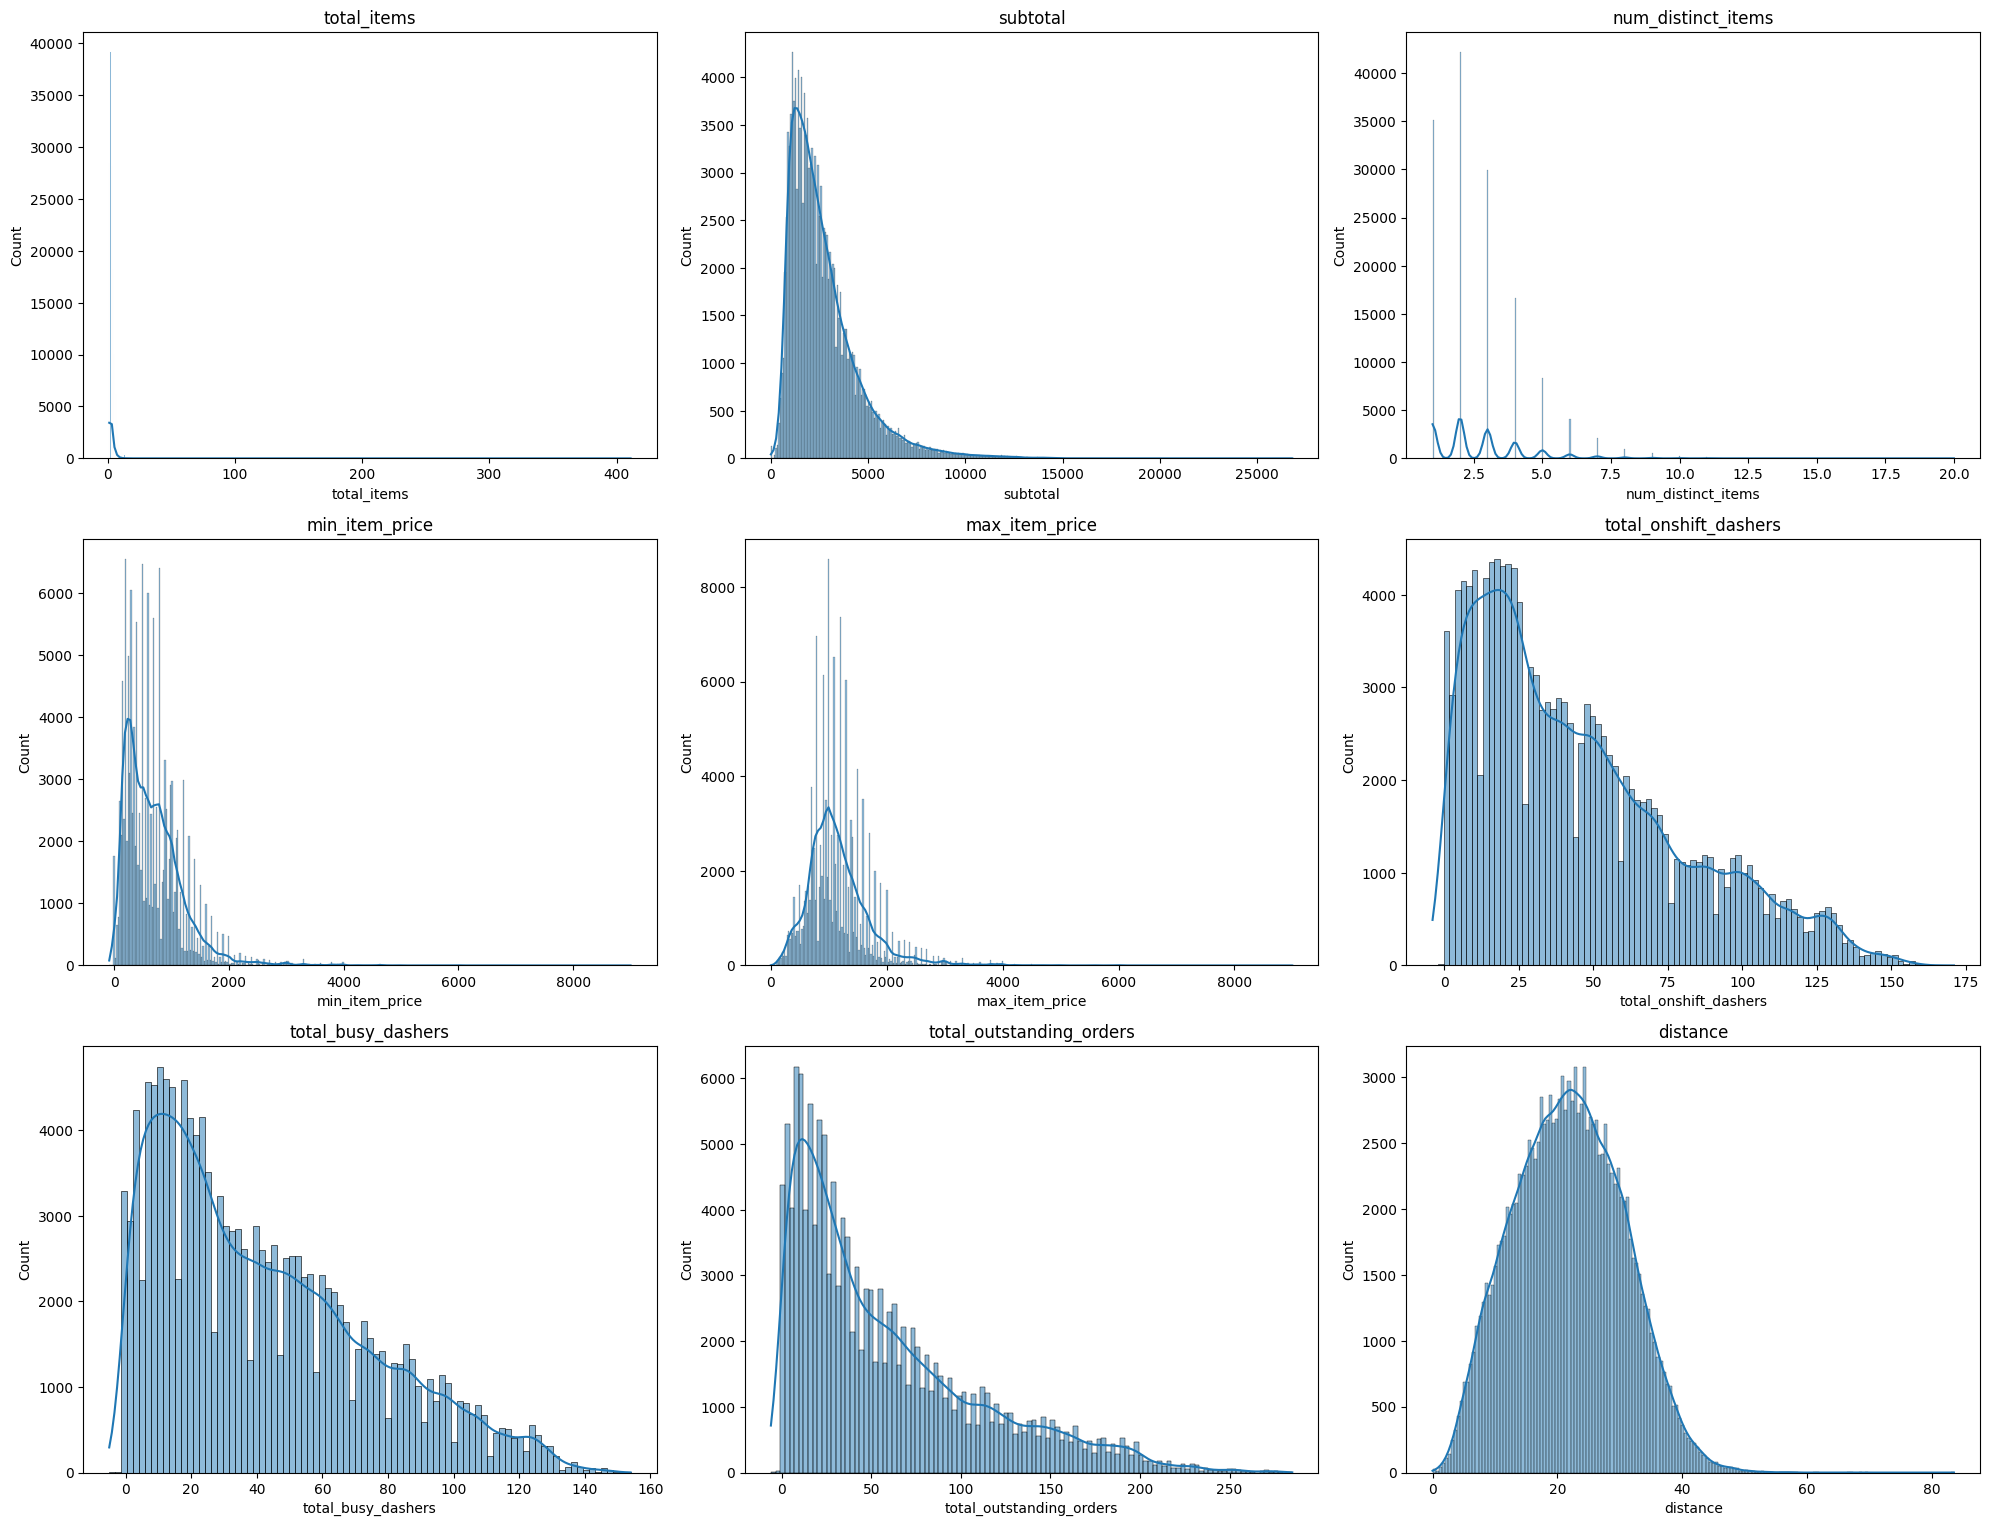

In [14]:
# Plot distributions for all numerical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.histplot(porter_data_train[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

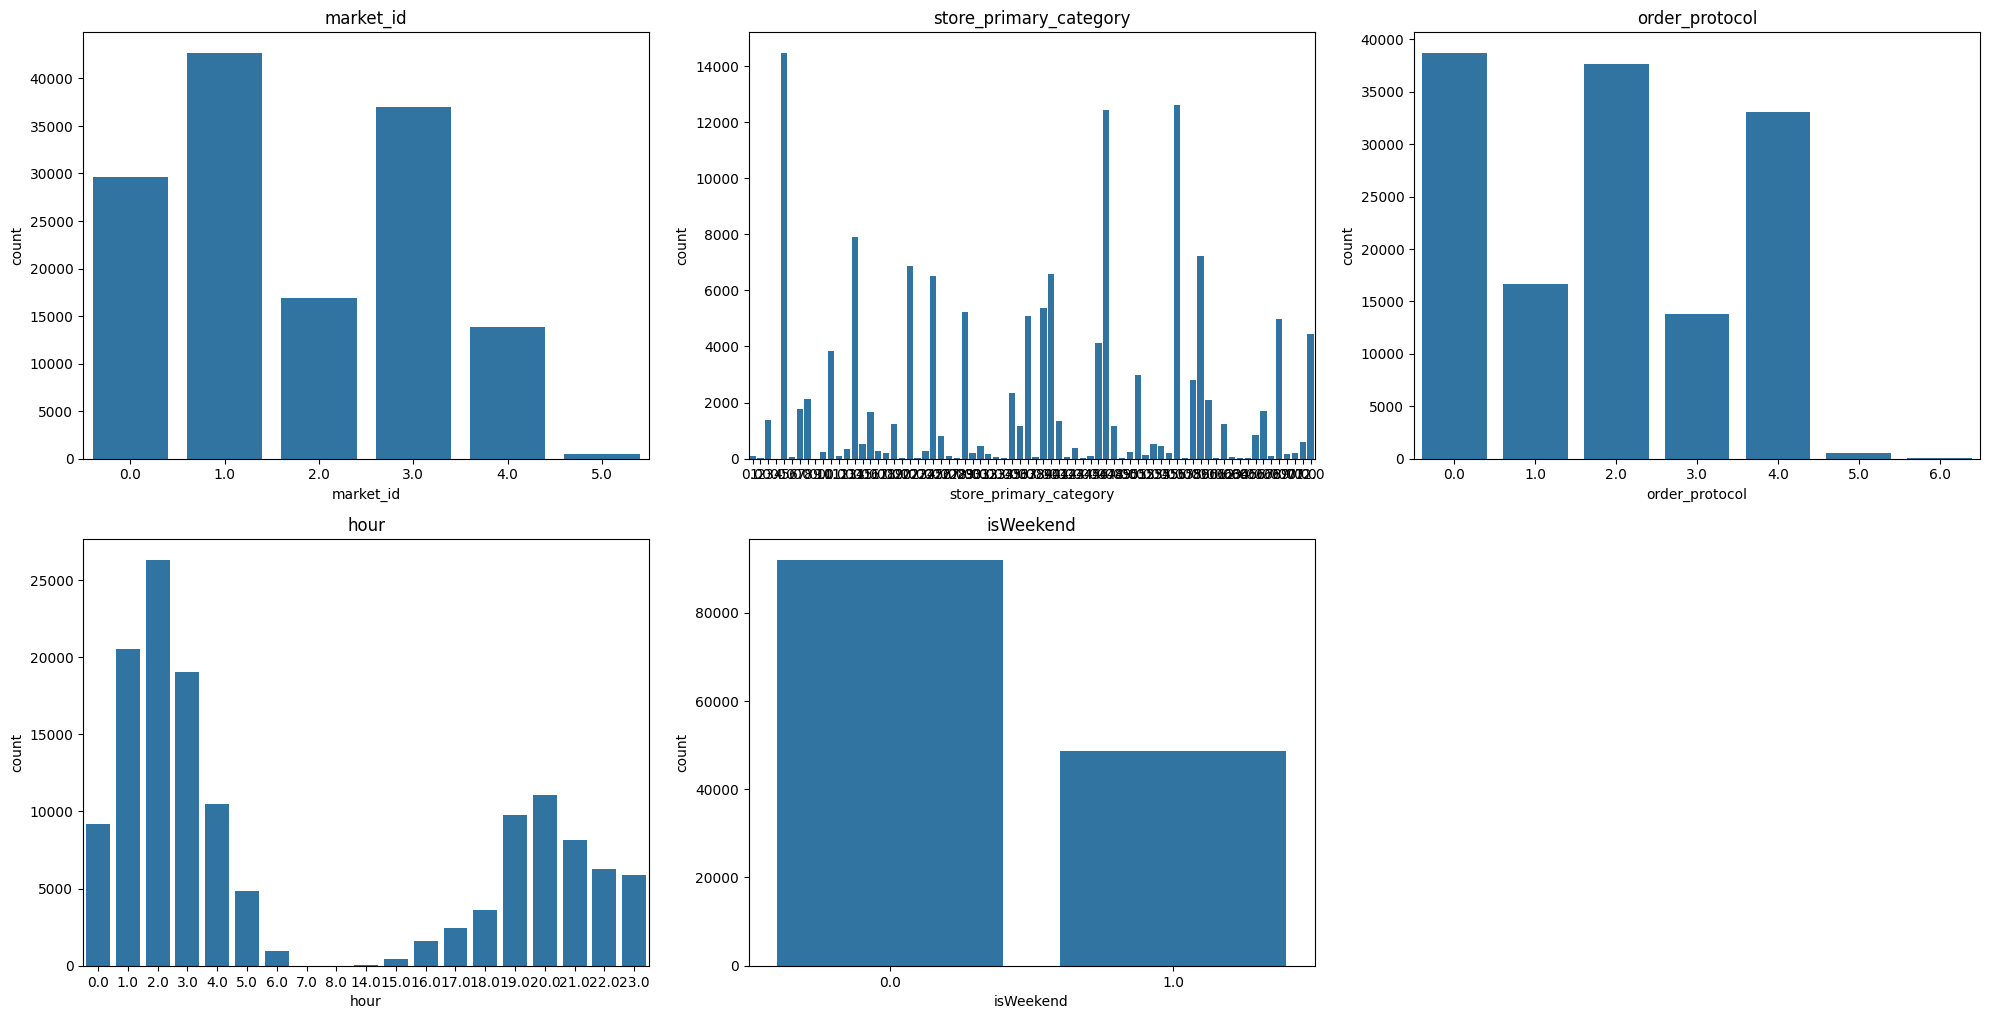

In [15]:
# Distribution of categorical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(cat_cols):
    plt.subplot(4, 3, i+1)
    sns.countplot(x=porter_data_train[col])
    plt.title(col)
    plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

<Axes: xlabel='time_taken', ylabel='Count'>

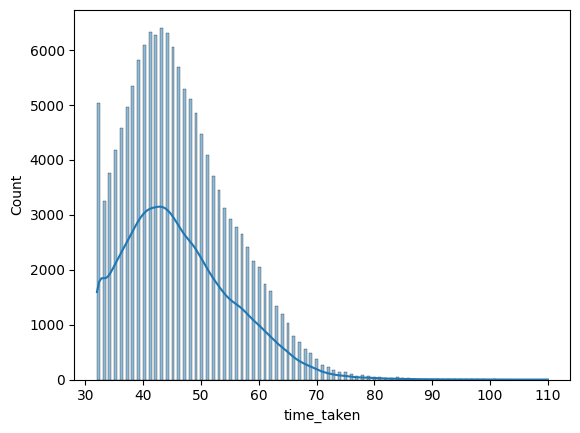

In [16]:
# Distribution of time_taken
sns.histplot(porter_data_train['time_taken'], kde=True)

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

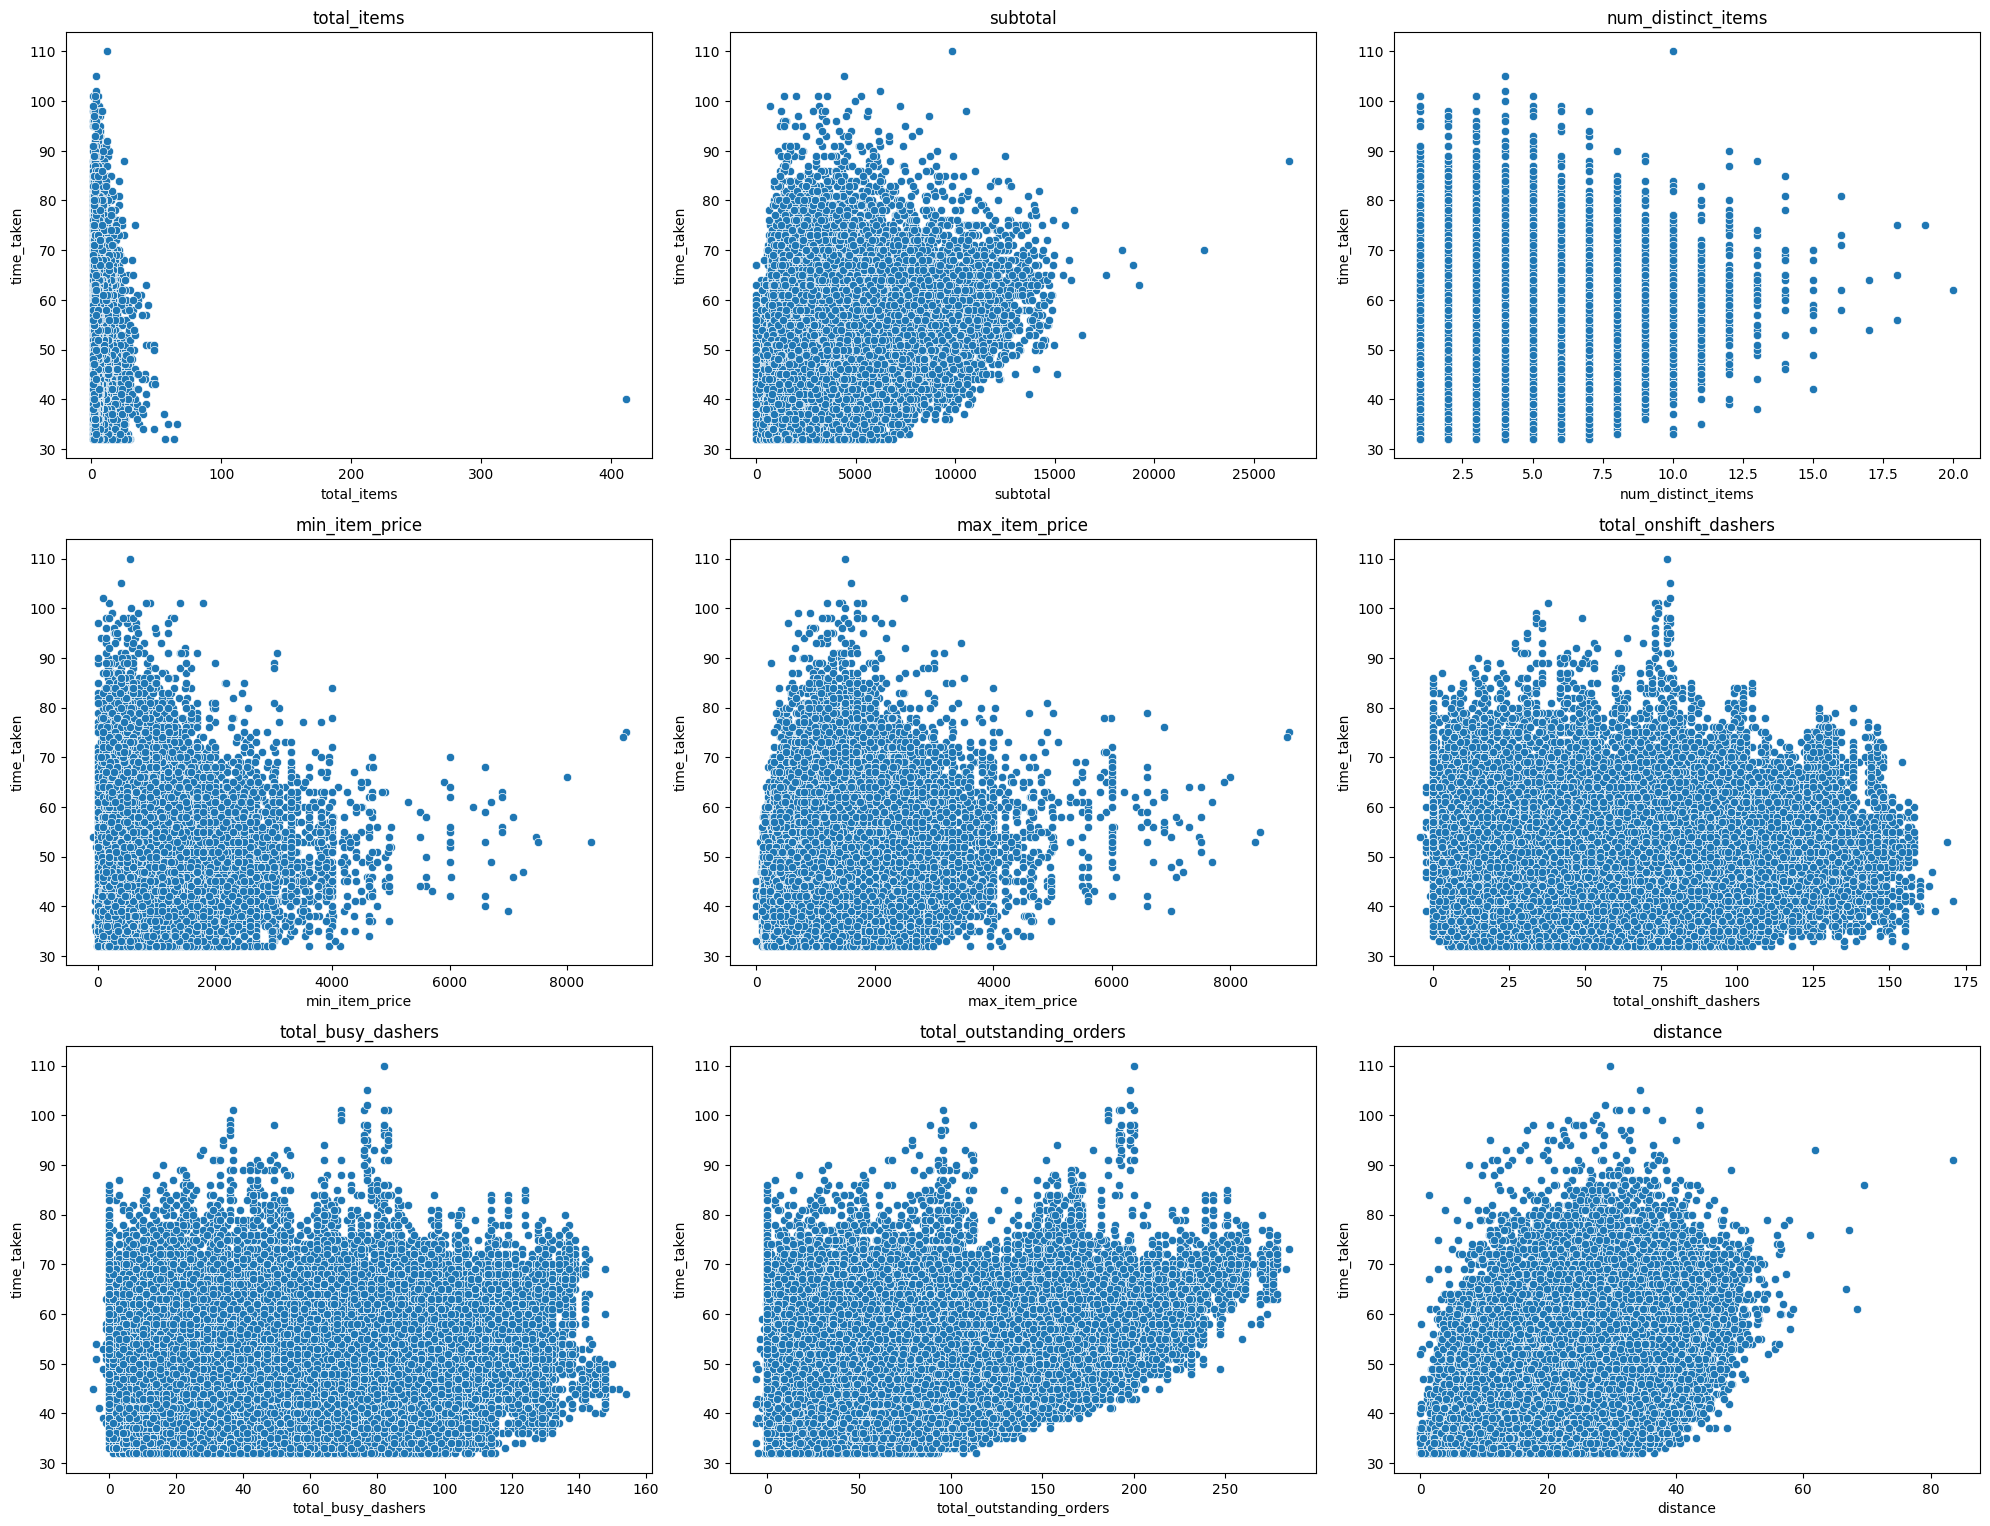

In [17]:
# Scatter plot to visualise the relationship between time_taken and other features
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.scatterplot(x=porter_data_train[col], y=porter_data_train['time_taken'])
    plt.title(col)
    plt.tight_layout()
plt.show()


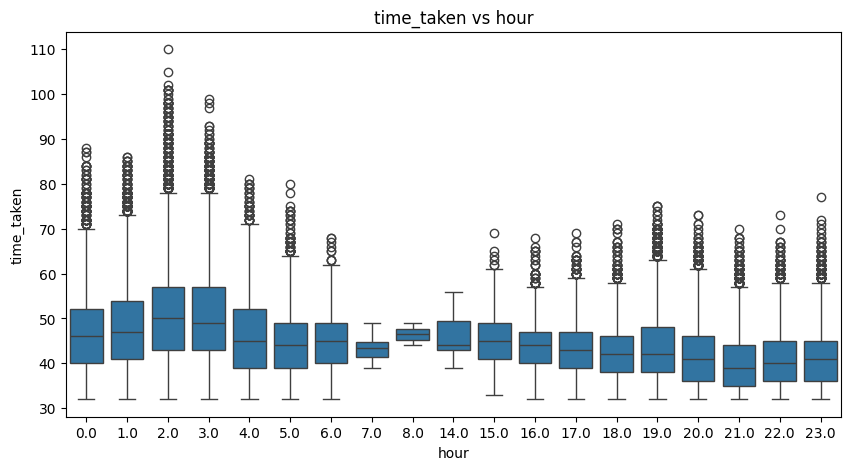

In [18]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y=porter_data_train['time_taken'], data=porter_data_train)
plt.title('time_taken vs hour')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

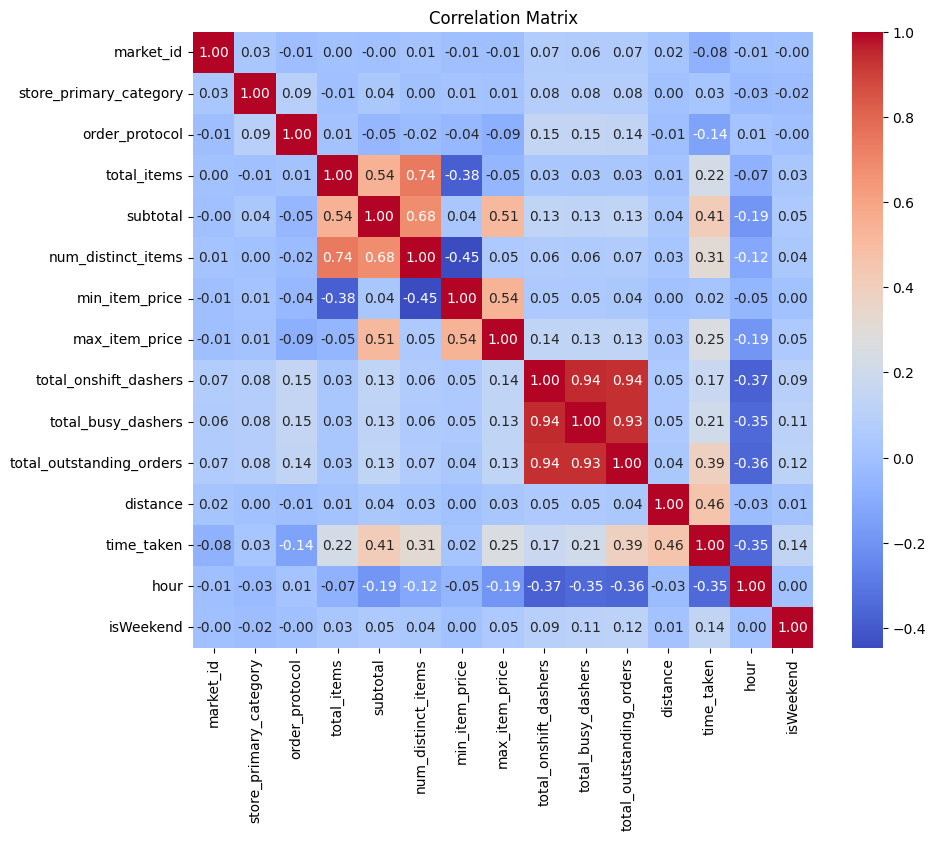

In [19]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(porter_data_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# Calculate correlation with 'time_taken' for all features
correlation_with_time_taken = porter_data.corr()['time_taken'].sort_values(ascending=False)
correlation_rank = correlation_with_time_taken.reset_index()
correlation_rank.columns = ['Feature', 'Correlation']
correlation_rank['Rank'] = correlation_rank['Correlation'].rank(ascending=False)

print(correlation_rank)

                     Feature  Correlation  Rank
0                 time_taken     1.000000   1.0
1                   distance     0.460173   2.0
2                   subtotal     0.413267   3.0
3   total_outstanding_orders     0.384999   4.0
4         num_distinct_items     0.312055   5.0
5             max_item_price     0.255167   6.0
6                total_items     0.224856   7.0
7         total_busy_dashers     0.206045   8.0
8      total_onshift_dashers     0.171015   9.0
9                  isWeekend     0.136414  10.0
10    store_primary_category     0.026973  11.0
11            min_item_price     0.022753  12.0
12                 market_id    -0.073016  13.0
13            order_protocol    -0.136755  14.0
14                      hour    -0.346366  15.0


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [21]:
# Drop 3-5 weakly correlated columns from training dataset based upon the correlation matrix
porter_data_train.drop(['hour','order_protocol','market_id', 'store_primary_category','min_item_price'], axis=1, inplace=True)

In [22]:
porter_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140621 entries, 102712 to 121958
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   total_items               140621 non-null  float32
 1   subtotal                  140621 non-null  float32
 2   num_distinct_items        140621 non-null  float32
 3   max_item_price            140621 non-null  float32
 4   total_onshift_dashers     140621 non-null  float32
 5   total_busy_dashers        140621 non-null  float32
 6   total_outstanding_orders  140621 non-null  float32
 7   distance                  140621 non-null  float32
 8   time_taken                140621 non-null  float32
 9   isWeekend                 140621 non-null  float32
dtypes: float32(10)
memory usage: 6.4 MB


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

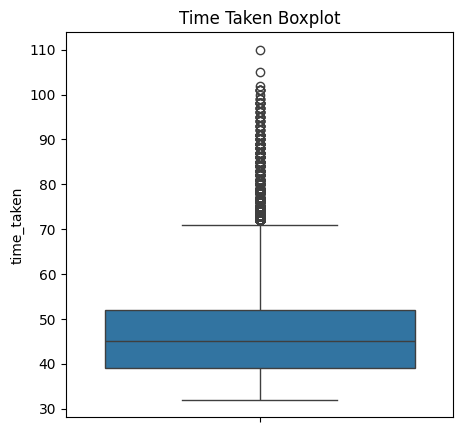

In [23]:
num_cols = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
cat_cols = ['isWeekend']

# Boxplot for time_taken
plt.figure(figsize=(5, 5))
sns.boxplot(porter_data_train['time_taken'])
plt.title('Time Taken Boxplot')
plt.show()

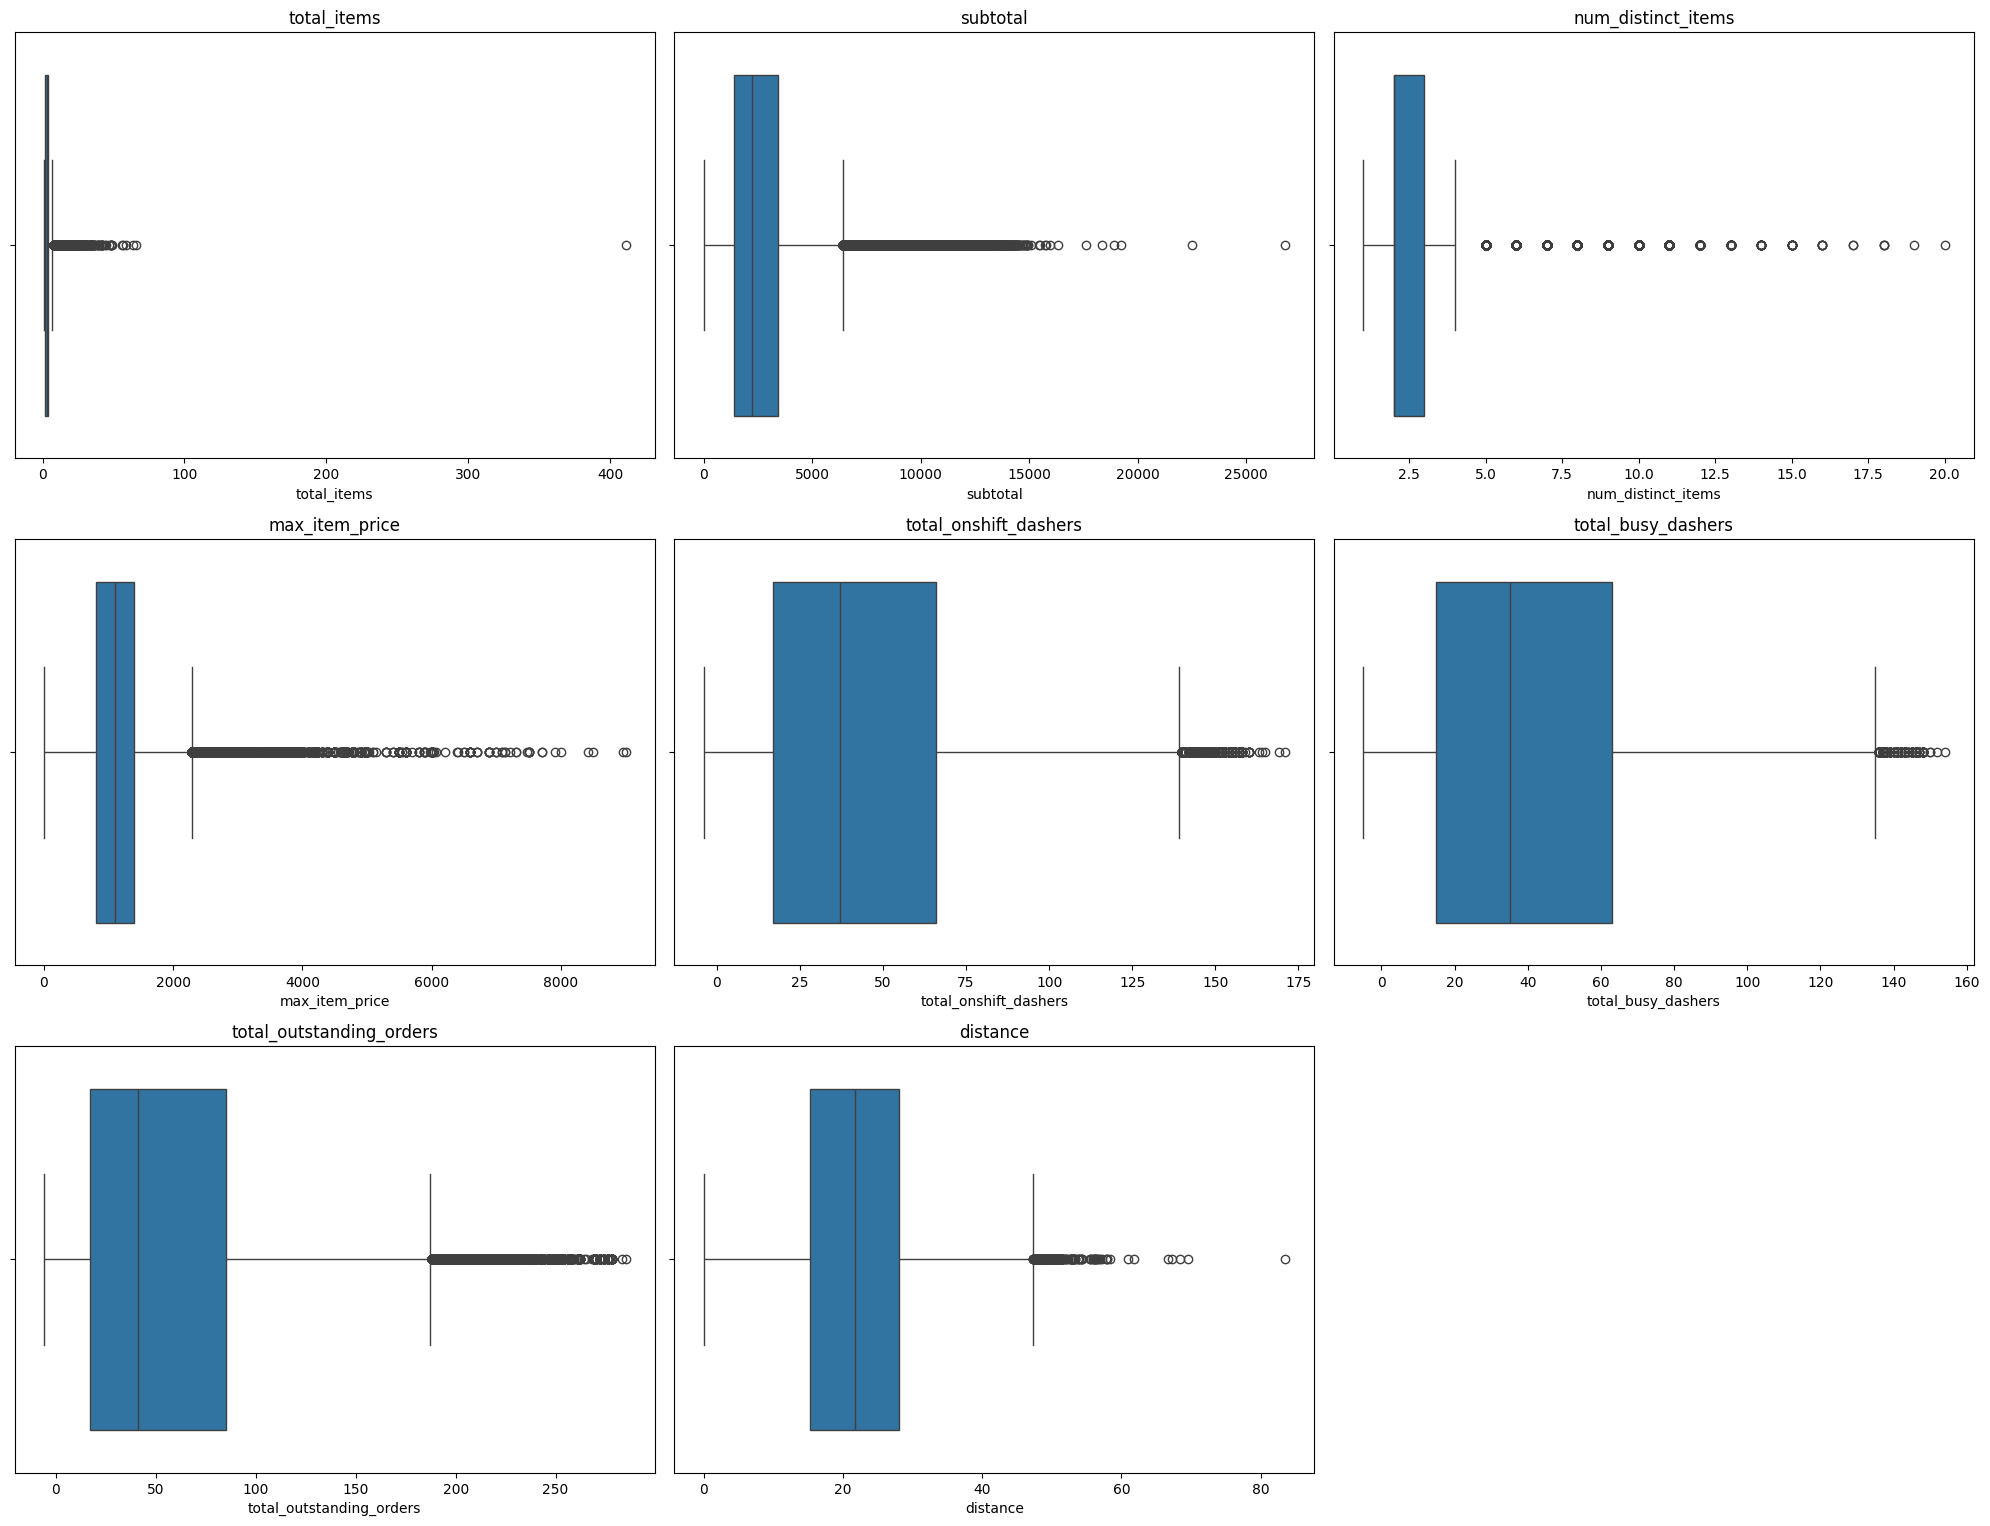

In [24]:
# visualization of outliers using boxplot for numerical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=porter_data_train[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [25]:
# Handle outliers
porter_data_train.drop(porter_data_train[porter_data_train['total_items'] > 100].index, inplace=True) # 1 record
porter_data_train.drop(porter_data_train[porter_data_train['subtotal'] > 15000].index, inplace=True) # 13 records
porter_data_train.drop(porter_data_train[porter_data_train['num_distinct_items'] > 15].index, inplace=True) # 12 records
porter_data_train.drop(porter_data_train[porter_data_train['distance'] > 60].index, inplace=True) # 7 records

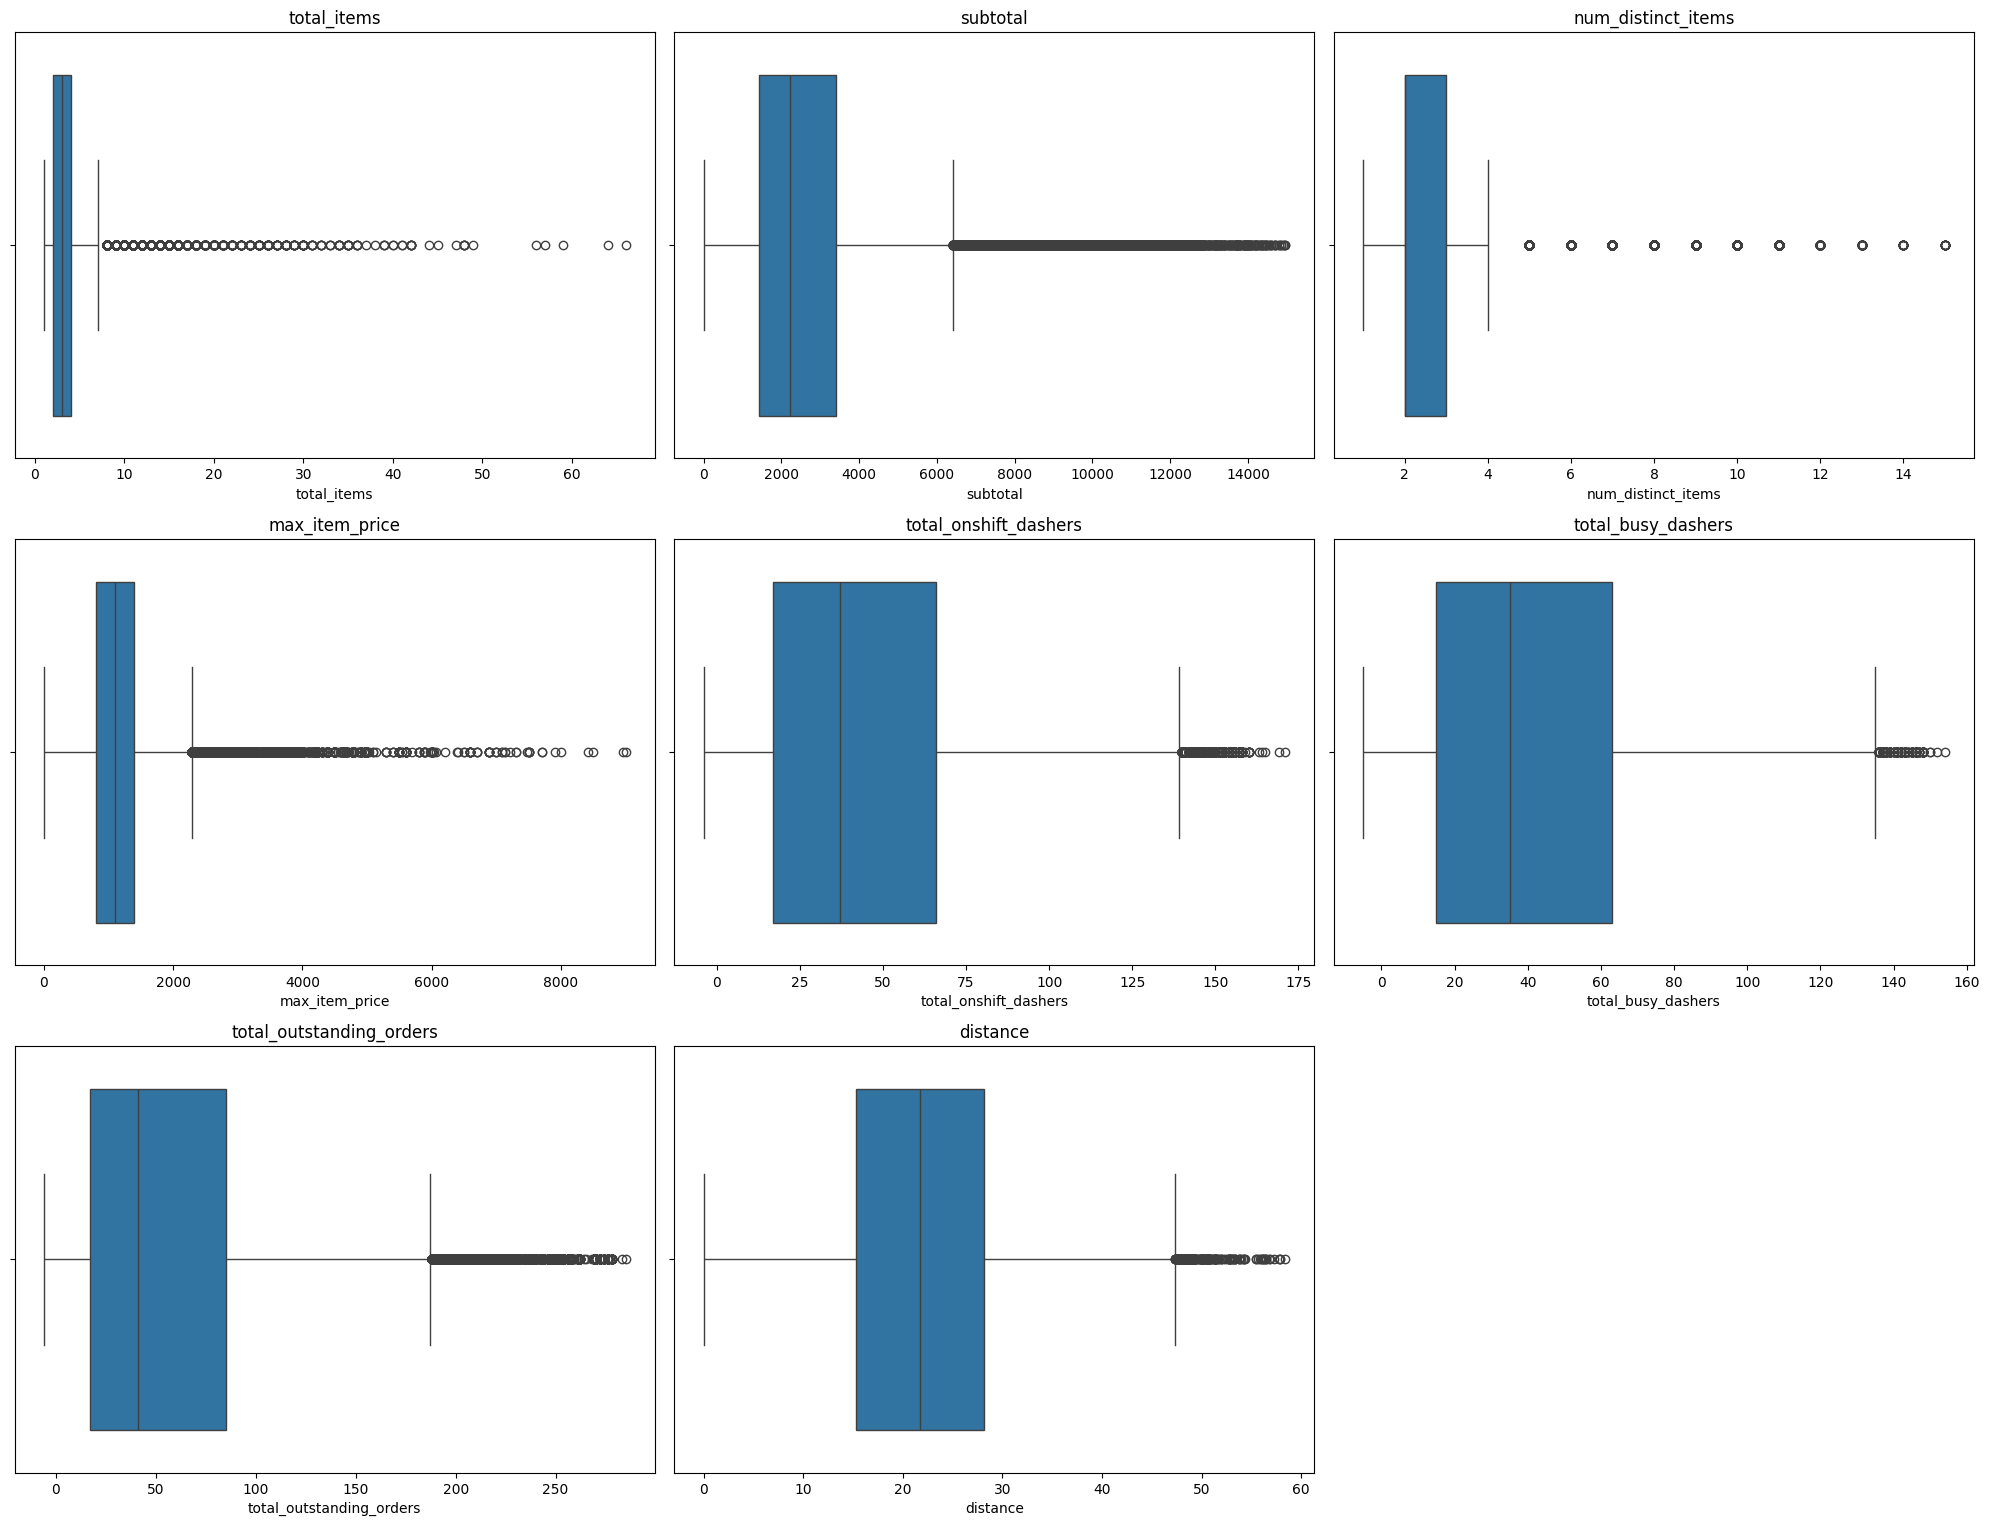

In [26]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=porter_data_train[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [27]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols = ['total_items','subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price','total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders', 'distance']
cat_cols = ['market_id', 'store_primary_category', 'order_protocol', 'hour', 'isWeekend']

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

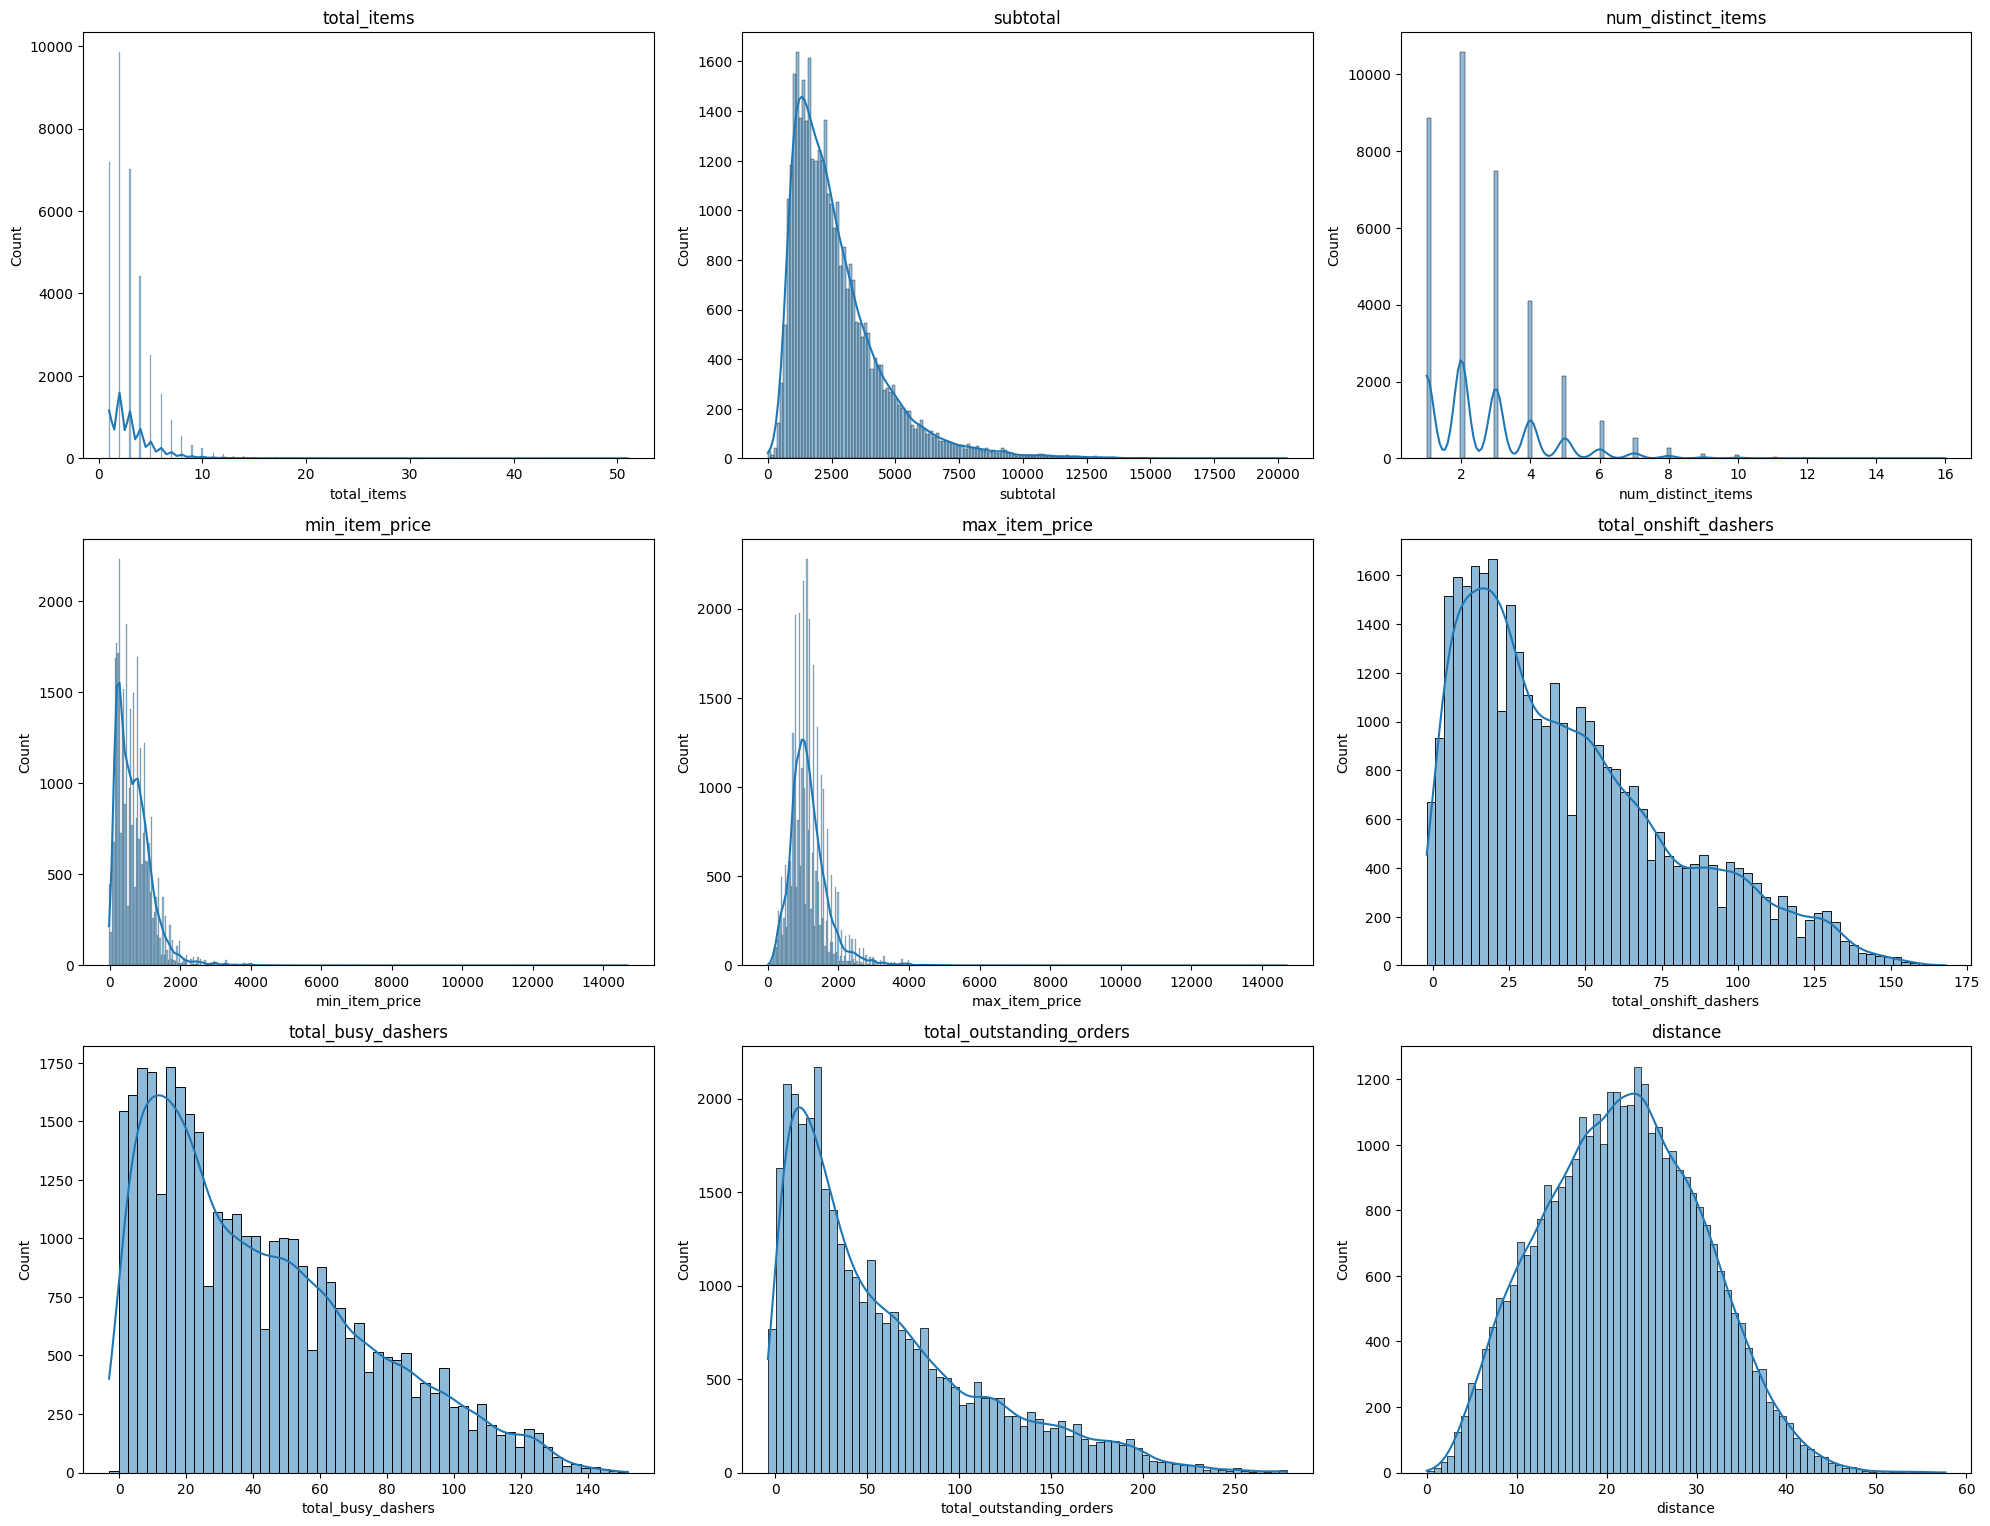

In [28]:
# Plot distributions for all numerical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.histplot(porter_data_test[col], kde=True)
    plt.title(col)
    plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

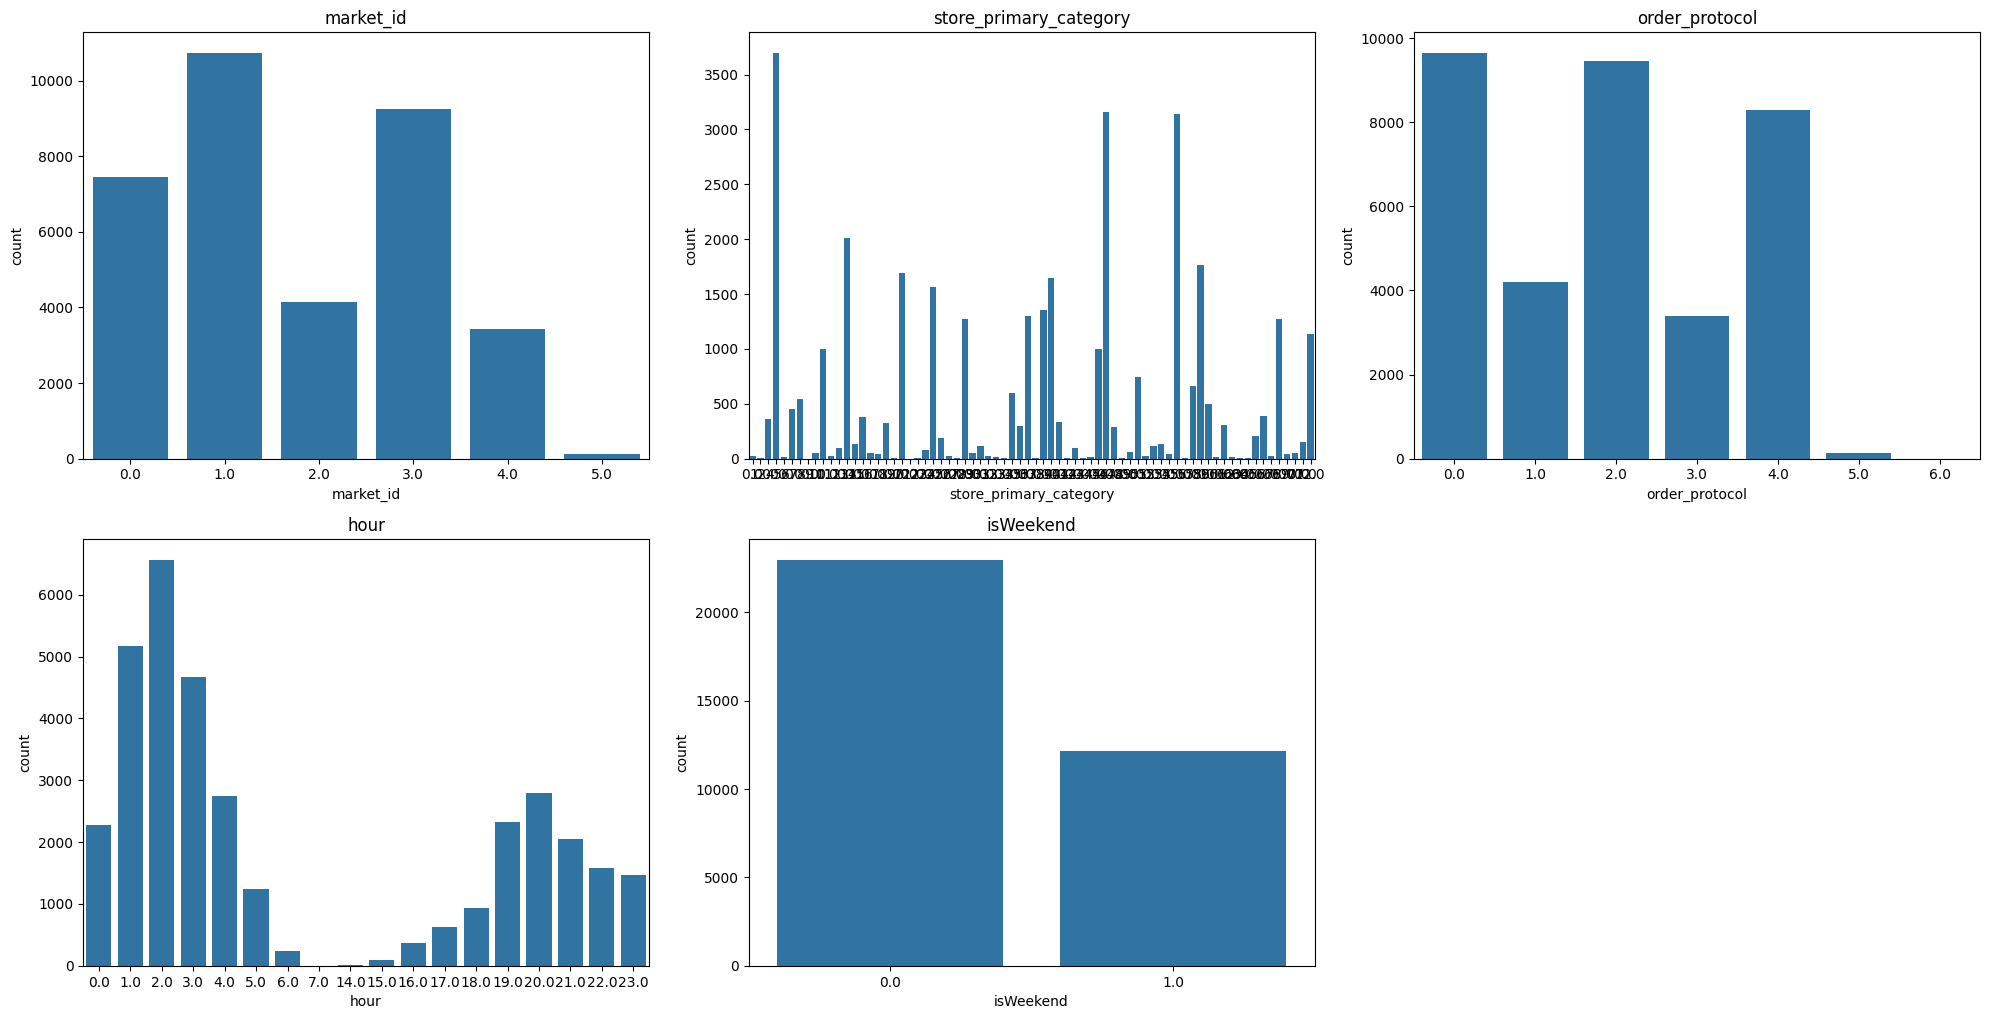

In [29]:
# Distribution of categorical columns
plt.figure(figsize=(20, 20))
for i, col in enumerate(cat_cols):
    plt.subplot(4, 3, i+1)
    sns.countplot(x=porter_data_test[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

<Axes: xlabel='time_taken', ylabel='Count'>

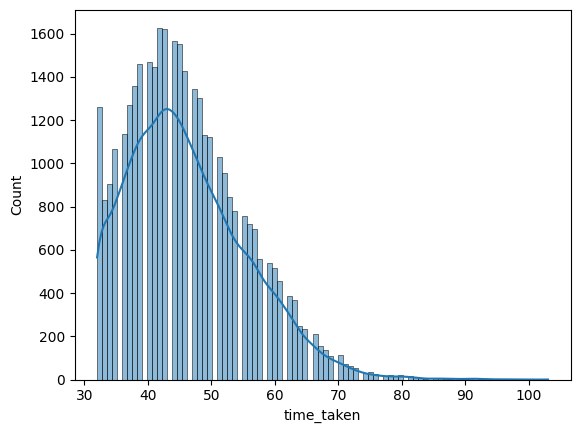

In [30]:
# Distribution of time_taken
sns.histplot(porter_data_test['time_taken'], kde=True)

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

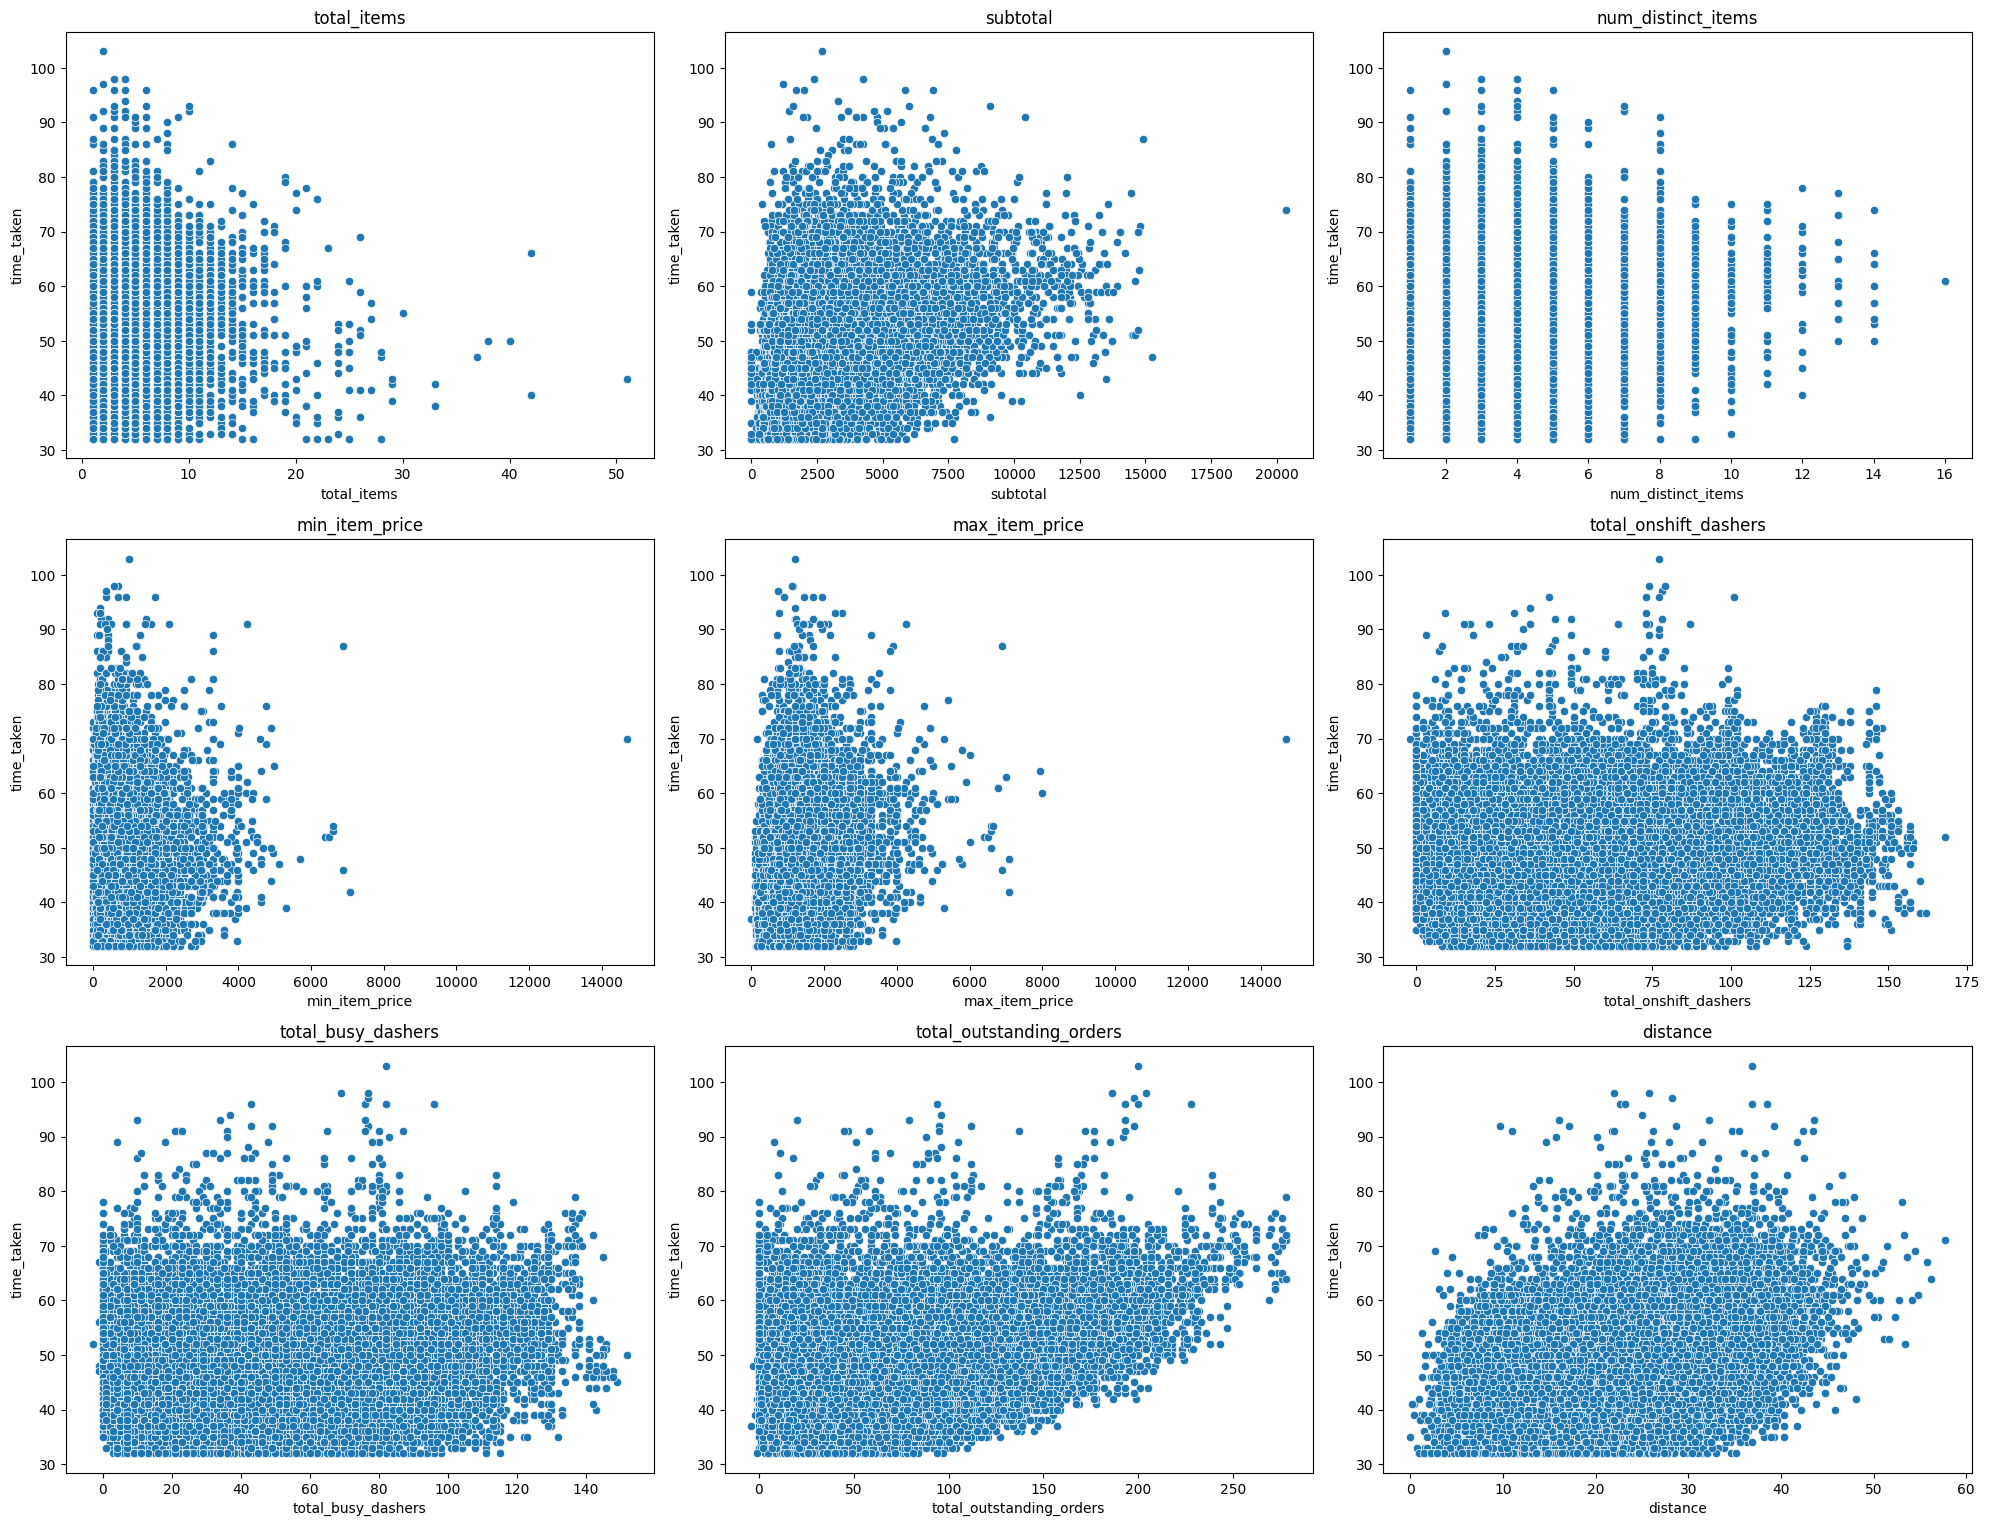

In [31]:
# Scatter plot to visualise the relationship between time_taken and other features
plt.figure(figsize=(20, 20))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i+1)
    sns.scatterplot(x=porter_data_test[col], y=porter_data_test['time_taken'])
    plt.title(col)
    plt.tight_layout()
plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [32]:
# Drop the weakly correlated columns from training dataset
correlation_with_time_taken = porter_data.corr()['time_taken'].sort_values(ascending=False)

correlation_rank = correlation_with_time_taken.reset_index()
correlation_rank.columns = ['Feature', 'Correlation']
correlation_rank['Rank'] = correlation_rank['Correlation'].rank(ascending=False)

print(correlation_rank)

                     Feature  Correlation  Rank
0                 time_taken     1.000000   1.0
1                   distance     0.460173   2.0
2                   subtotal     0.413267   3.0
3   total_outstanding_orders     0.384999   4.0
4         num_distinct_items     0.312055   5.0
5             max_item_price     0.255167   6.0
6                total_items     0.224856   7.0
7         total_busy_dashers     0.206045   8.0
8      total_onshift_dashers     0.171015   9.0
9                  isWeekend     0.136414  10.0
10    store_primary_category     0.026973  11.0
11            min_item_price     0.022753  12.0
12                 market_id    -0.073016  13.0
13            order_protocol    -0.136755  14.0
14                      hour    -0.346366  15.0


In [33]:
porter_data_test.drop(['hour','order_protocol','market_id', 'store_primary_category','min_item_price'], axis=1, inplace=True)
porter_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35156 entries, 50609 to 49931
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   total_items               35156 non-null  float32
 1   subtotal                  35156 non-null  float32
 2   num_distinct_items        35156 non-null  float32
 3   max_item_price            35156 non-null  float32
 4   total_onshift_dashers     35156 non-null  float32
 5   total_busy_dashers        35156 non-null  float32
 6   total_outstanding_orders  35156 non-null  float32
 7   distance                  35156 non-null  float32
 8   time_taken                35156 non-null  float32
 9   isWeekend                 35156 non-null  float32
dtypes: float32(10)
memory usage: 1.6 MB


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [34]:
# Import libraries
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [35]:
porter_data_train.describe()

total_items       subtotal  num_distinct_items  max_item_price  \
count  140588.000000  140588.000000       140588.000000    140588.00000   
mean        3.202905    2696.807129            2.674560      1159.88147   
std         2.490472    1823.295166            1.618679       559.60083   
min         1.000000       0.000000            1.000000         0.00000   
25%         2.000000    1417.000000            2.000000       799.00000   
50%         3.000000    2225.000000            2.000000      1095.00000   
75%         4.000000    3414.000000            3.000000      1395.00000   
max        66.000000   14955.000000           15.000000      8999.00000   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count          140588.000000       140588.000000             140588.000000   
mean               44.927731           41.879429                 58.243172   
std                34.573502           32.198246                 52.773876   
min                -4.000000           -5.000000                 -6.000000   
25%                17.000000           15.000000                 17.000000   
50%                37.000000           35.000000                 41.000000   
75%                66.000000           63.000000                 85.000000   
max               171.000000          154.000000                285.000000   

            distance     time_taken      isWeekend  
count  140588.000000  140588.000000  140588.000000  
mean       21.838240      46.192867       0.345534  
std         8.745319       9.313481       0.475544  
min         0.000000      32.000000       0.000000  
25%        15.320000      39.000000       0.000000  
50%        21.760000      45.000000       0.000000  
75%        28.120001      52.000000       1.000000  
max        58.400002     110.000000       1.000000

In [36]:
# Apply scaling to the numerical columns
num_cols = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders', 'distance', 'time_taken']
cat_cols = ['isWeekend']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
porter_data_train[num_cols] = scaler.fit_transform(porter_data_train[num_cols]) # scaling the training data
porter_data_test[num_cols] = scaler.transform(porter_data_test[num_cols]) # scaling the testing data

In [37]:
porter_data_train.describe()

total_items      subtotal  num_distinct_items  max_item_price  \
count  1.405880e+05  1.405880e+05        1.405880e+05    1.405880e+05   
mean  -1.400108e-08 -9.930998e-09        9.659660e-09    6.512130e-10   
std    1.000004e+00  1.000004e+00        1.000004e+00    1.000003e+00   
min   -8.845363e-01 -1.479089e+00       -1.034526e+00   -2.072702e+00   
25%   -4.830045e-01 -7.019224e-01       -4.167361e-01   -6.448933e-01   
50%   -8.147278e-02 -2.587671e-01       -4.167361e-01   -1.159429e-01   
75%    3.200590e-01  3.933513e-01        2.010537e-01    4.201554e-01   
max    2.521503e+01  6.723123e+00        7.614532e+00    1.400846e+01   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count           1.405880e+05        1.405880e+05              1.405880e+05   
mean            2.258895e-08        5.725248e-09              2.048608e-09   
std             1.000004e+00        1.000004e+00              1.000004e+00   
min            -1.415185e+00       -1.455967e+00             -1.217333e+00   
25%            -8.077814e-01       -8.348132e-01             -7.815101e-01   
50%            -2.293016e-01       -2.136592e-01             -3.267380e-01   
75%             6.094940e-01        6.559564e-01              5.070108e-01   
max             3.646513e+00        3.482208e+00              4.296778e+00   

           distance    time_taken      isWeekend  
count  1.405880e+05  1.405880e+05  140588.000000  
mean   7.706021e-09  6.729201e-09       0.345534  
std    1.000004e+00  1.000004e+00       0.475544  
min   -2.497144e+00 -1.523911e+00       0.000000  
25%   -7.453431e-01 -7.723100e-01       0.000000  
50%   -8.946502e-03 -1.280802e-01       0.000000  
75%    7.183023e-01  6.235211e-01       1.000000  
max    4.180738e+00  6.851075e+00       1.000000

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [38]:
# Create/Initialise the model
y_target = ['time_taken']
X_features = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'isWeekend']
y_train = porter_data_train[y_target]
X_train = porter_data_train[X_features]
print(X_train.shape)
print(y_train.shape)

(140588, 9)
(140588, 1)


In [39]:
# Train the model using the training data
X_train_lr = sm.add_constant(X_train[X_features]) # Add a constant
lr = sm.OLS(y_train, X_train_lr).fit() # Fit the model
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             time_taken   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                 6.848e+04
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:46:41   Log-Likelihood:                -81147.
No. Observations:              140588   AIC:                         1.623e+05
Df Residuals:                  140578   BIC:                         1.624e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0389      0.001    -27.283      0.000      -0.042      -0.036
total_items                 -0.0249      0.002    -12.118      0.000      -0.029      -0.021
subtotal                     0.2633      0.002    122.497      0.000       0.259       0.267
num_distinct_items           0.1167      0.002     53.089      0.000       0.112       0.121
max_item_price               0.0760      0.002     47.689      0.000       0.073       0.079
total_onshift_dashers       -1.2903      0.004   -326.886      0.000      -1.298      -1.283
total_busy_dashers          -0.5191      0.004   -135.298      0.000      -0.527      -0.512
total_outstanding_orders     2.0019      0.004    552.745      0.000       1.995       2.009
distance                     0.4481      0.001    389.075      0.000       0.446       0.450
isWeekend                    0.1126      0.002     46.105      0.000       0.108       0.117
==============================================================================
Omnibus:                    31350.474   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86873.135
Skew:                           1.187   Prob(JB):                         0.00
Kurtosis:                       6.032   Cond. No.                         7.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Re-training the model by adding the variables one by one based upon the correlation matrix
y_target_1 = ['time_taken']
X_features_1 = ['subtotal','total_items', 'total_outstanding_orders', 'distance','isWeekend','total_onshift_dashers']
y_train = porter_data_train[y_target_1]
X_train = porter_data_train[X_features_1]

X_train_lr = sm.add_constant(X_train[X_features_1]) # Add a constant
lr = sm.OLS(y_train, X_train_lr).fit() # Fit the model
print(lr.summary())

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_lr_vif = X_train_lr.drop(['const'], axis=1)

vif = pd.DataFrame()
X = X_train_lr_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# After multiple hit and trial and playing with multiple variable, this model looks as it has good r square value & p-values are < 0.05
# Also w.r.t to coef values, for 'total_onshift_dashers' we see a negative value, which means it has impact on the target variable.

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 8.524e+04
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:46:41   Log-Likelihood:                -91635.
No. Observations:              140588   AIC:                         1.833e+05
Df Residuals:                  140581   BIC:                         1.834e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [41]:
# Make predictions
y_test = porter_data_test[y_target_1]
X_test = porter_data_test[X_features_1]
print(X_test.shape)
print(y_test.shape)

X_test_lr = sm.add_constant(X_test[X_features_1]) # Add a constant
y_pred = lr.predict(X_test_lr)

r_squared = r2_score(y_test, y_pred) # we can see that the r-squared value is 0.784, which pretty close to with our training data r-squared value 0.785
print(f'r_squared : {r_squared}')

(35156, 6)
(35156, 1)
r_squared : 0.7856536557612598


Text(0, 0.5, 'y_pred')

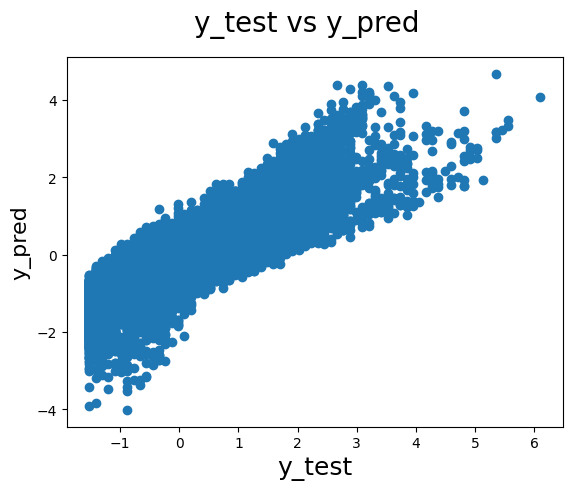

In [42]:
# Find results for evaluation metrics
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)     

Text(0.5, 0, 'Errors')

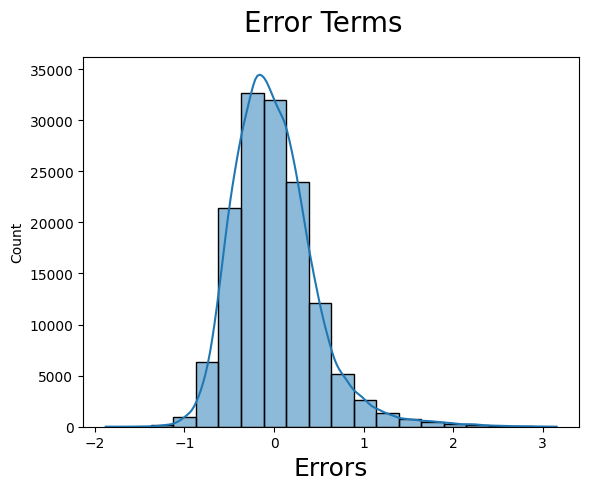

In [43]:
#Residual Analysis

y_target_pred = lr.predict(X_train_lr)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig = plt.figure()
sns.histplot((y_train['time_taken'] - y_target_pred), bins = 20, kde=True)
fig.suptitle('Error Terms', fontsize = 20)                 
plt.xlabel('Errors', fontsize = 18)     

# The error terms are normally distributed (which is one of the major assumptions of linear regression).

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [44]:
y_target = ['time_taken']
X_features = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'isWeekend']
y_train = porter_data_train[y_target]
X_train = porter_data_train[X_features]
print(X_train.shape)
print(y_train.shape)

(140588, 9)
(140588, 1)


In [45]:
# Loop through the number of features and test the model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

X_train_new = X_train

# Build the final model with selected number of features
lm = LinearRegression()
lm.fit(X_train_new, y_train)

rfe = RFE(lm, n_features_to_select=8)  # running RFE
rfe = rfe.fit(X_train_new, y_train)
list(zip(X_train_new.columns, rfe.support_,rfe.ranking_))

[('total_items', np.False_, np.int64(2)),
 ('subtotal', np.True_, np.int64(1)),
 ('num_distinct_items', np.True_, np.int64(1)),
 ('max_item_price', np.True_, np.int64(1)),
 ('total_onshift_dashers', np.True_, np.int64(1)),
 ('total_busy_dashers', np.True_, np.int64(1)),
 ('total_outstanding_orders', np.True_, np.int64(1)),
 ('distance', np.True_, np.int64(1)),
 ('isWeekend', np.True_, np.int64(1))]

In [46]:
col = X_train_new.columns[rfe.support_]
X_train_rfe = X_train_new[col]

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                 7.694e+04
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:46:44   Log-Likelihood:                -81221.
No. Observations:              140588   AIC:                         1.625e+05
Df Residuals:                  140579   BIC:                         1.625e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [47]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_rfe_vif = X_train_rfe.drop(['const'], axis=1)

vif = pd.DataFrame()
X = X_train_rfe_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
3     total_onshift_dashers  11.77
4        total_busy_dashers  11.13
5  total_outstanding_orders   9.91
0                  subtotal   3.24
1        num_distinct_items   2.40
2            max_item_price   1.75
7                 isWeekend   1.01
6                  distance   1.00

In [48]:
# As the VIF of couple of features are high where as the p-values < 0.05 and coef is negative, which means 'total_onshift_dashers' and 'total_busy_dashers' are multicollinear with other features, 
# but also will impacting the delivery time. Hwowever dropping 'total_busy_dashers' doesn't have much impact on the r-sqr value and it's still pretty good i.e. 79 %, 
# where as we cannot drop 'total_onshift_dashers' as dropping both of them impacting the model r -sqr value less than 50 %

# On the other hand, 'num_distinct_items' and 'max_item_price', doesn't have much impact on the delivery time, as there coef is very low/-ve 
# and dropping doesn't them impact the model r sqr value much, and we can end up with 78.4 % r-sqr value.

# Rebuilding the model

X_train_rfe_final = X_train_rfe.drop(['total_busy_dashers','num_distinct_items','max_item_price'], axis=1) # dropping the features with high VIF.

# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe_final = sm.add_constant(X_train_rfe_final)

lm_final = sm.OLS(y_train,X_train_rfe_final).fit()   # Running the linear model

print(lm_final.summary())

# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_rfe_vif = X_train_rfe_final.drop(['const'], axis=1)
vif = pd.DataFrame()
X = X_train_rfe_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.023e+05
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:46:44   Log-Likelihood:                -91651.
No. Observations:              140588   AIC:                         1.833e+05
Df Residuals:                  140582   BIC:                         1.834e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [49]:
X_features = X_train_rfe_vif.columns

# Make predictions (calulating the MSE and r-sqr value)
y_test = porter_data_test[y_target]
X_test = porter_data_test[X_features]
print(X_test.shape)
print(y_test.shape)

# Ensure the features match those used in training the model
X_test_lm = sm.add_constant(X_test[X_features]) # Add a constant
y_pred_lm = lm_final.predict(X_test_lm)

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred_lm) # we can see that the r-squared value for predicted y value is 0.791, which pretty close to with our training data r-squared value 0.790

print('Mean_Squared_Error :' ,mse) # mean square error is low, which is good and also validates that the model is good
print(f'r_squared : {r_squared}')

(35156, 5)
(35156, 1)
Mean_Squared_Error : 0.21629104160122445
r_squared : 0.7855919379188178


Text(0.5, 0.98, 'Error Terms')

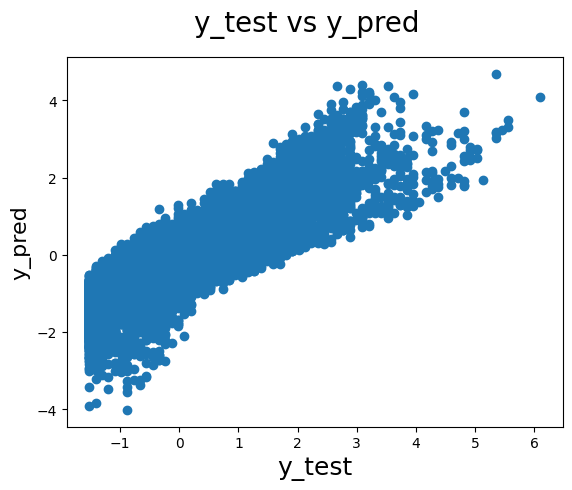

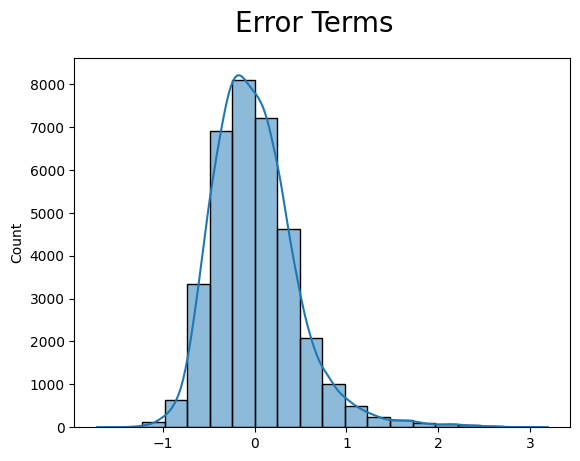

In [50]:
# Model evaluation metrics
fig = plt.figure()
plt.scatter(y_test,y_pred_lm)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

# Error terms
fig = plt.figure()
sns.histplot((y_test['time_taken'] - y_pred_lm), bins = 20, kde=True)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading

# The error terms are normally distributed (which is one of the major assumptions of linear regression).


Text(0, 0.5, 'time_taken')

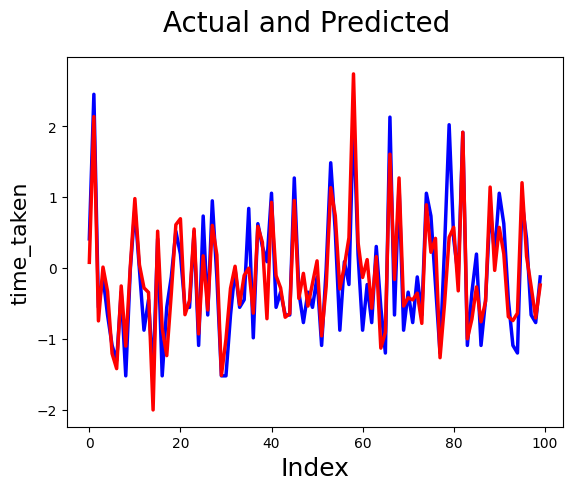

In [51]:
# Making predictions using the model, taken 100 samples and compared it the predicted values, 
# and the predicted values are highly overlapping with the actual value, which denotes that the model is predicting well. 

test = porter_data_test.head(100)
X = test[X_features]
X = sm.add_constant(X)
Predicted_time_taken = lm_final.predict(X)

#Actual vs Predicted
c = [i for i in range(0,100,1)]
fig = plt.figure()
plt.plot(c,test.time_taken, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,Predicted_time_taken, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('time_taken', fontsize=16)  

Text(0, 0.5, 'ytest-ypred')

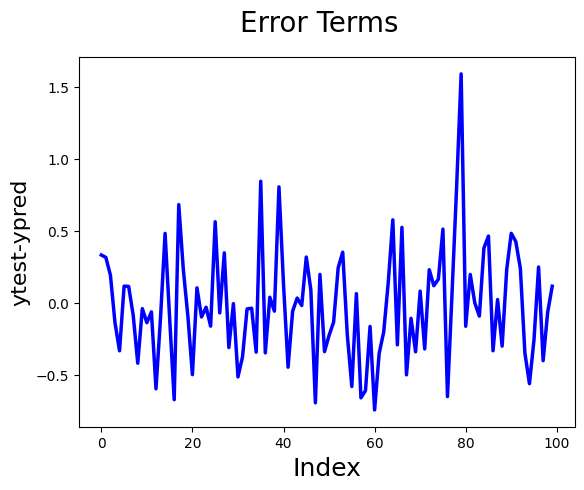

In [52]:
# Error terms
c = [i for i in range(0,100,1)]
fig = plt.figure()
plt.plot(c,test.time_taken - Predicted_time_taken, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('ytest-ypred', fontsize=16) 

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

Text(0.5, 0, 'Errors')

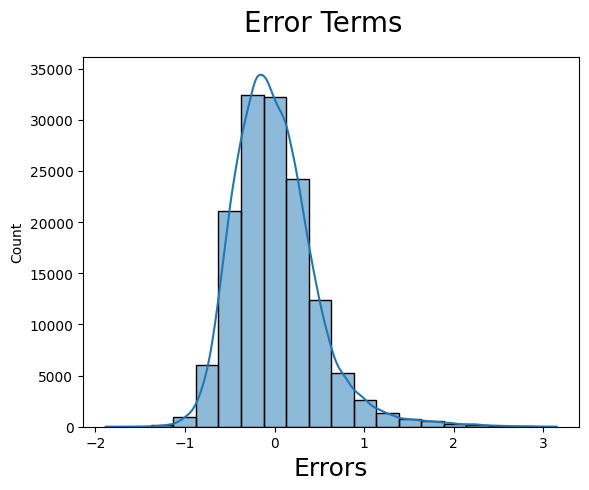

In [53]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
y_target_pred = lm_final.predict(X_train_rfe_final)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig = plt.figure()
sns.histplot((y_train['time_taken'] - y_target_pred), bins = 20, kde=True)
fig.suptitle('Error Terms', fontsize = 20)                 
plt.xlabel('Errors', fontsize = 18)    

[Your inferences here:]
- For both the model i.e linear regression with and without RFE, the error terms are normally distributed (which is one of the major assumptions of linear regression).



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [54]:
# Compare the scaled vs unscaled features used in the final model

X=porter_data[X_features]
y=porter_data['time_taken'].values

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=42)


baseline = LinearRegression()
scaler=StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create standard scaler for the target variable
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Fit the model to the training data
baseline.fit(X_train_scaled, y_train_scaled)

# Make predictions on the testing data
y_pred_scaled = baseline.predict(X_test_scaled)

X_test_unscaled = scaler.inverse_transform(X_test_scaled)
y_test_unscaled = scaler.inverse_transform(y_test_scaled)
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

#Calculate R-squared and RMSE on the unscaled testing data
r_squared = r2_score(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

# Print the R-squared and RMSE
print('R-squared:', r_squared)
print('RMSE:', rmse)

R-squared: 0.7855857014656067
RMSE: 4.332101475634017


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [55]:
# Analyze the effect of a unit change in a feature, say 'total_items'

coef_total_items = lr.params['total_items']
print(f"total_items coefficient:",coef_total_items)

std_total_items = porter_data['total_items'].std()

effect_unit_change = coef_total_items * std_total_items

print(f"Effect of a unit change: {effect_unit_change:.4f}")

# 

total_items coefficient: 0.008647233098742527
Effect of a unit change: 0.0231


Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> Yes, below are categorical variables in the data :
1. market_id
2. store_primary_category
3. order_protocol
4. hour
5. isWeekend

From my analysis:
- *market_id*, *store_primary_category*, and *order_protocol* were found to have weak correlations with the dependent variable (*time_taken*) and were dropped.
- *hour* showed a relationship with *time_taken* in the form of variations in delivery time, but it was also dropped due to weak negative correlation.
- *isWeekend* was kept as it had shown a significant impact on *time_taken*, and had a positive correlation compared to other categorical variables.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> The parameter `test_size = 0.2` refers to the proportion of dataset allocated to the test set during the train-test split. 
In this case, 20% of the data is used for testing, while the remaining 80% is used for training the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> *Distance* has high correlation value - 0.460173 with the target varibale *time_taken*



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> To detect outliers, I used boxplots for numerical features and the target variable (*time_taken*). It helped to visualize the spread of data and identify extreme values.
Have found outliers for *total_items*, *subtotal* & *distance*, & as the they are very few records, so dropped in the EDA process from both traning and test dataset.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Based upon the coefficient and p-value of my final model, below are top 3 features which are affecting the delivery time

1. total_outstanding_orders     
2. total_onshift_dashers
3. distance



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>

- Linear regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more input features. 
- It assumes a linear relationship between the input features (independent variables) and the target variable (dependent variable).
- Regression is the most commonly used predictive analysis model
- There are 2 types of linear regression
    1. **Simple linear regression**
        - Involves one independent variable.
        - Example: Predicting house price based on its size.
    2. **Multiple linear regression**
        - Involves two or more independent variables.
        - Example: Predicting house price based on size, location, and number of bedrooms.
- Strengt of the linear regression model is accessed using 2 metrics
    1. R² or Coefficient of Determination
    2. Residual Standard Error (RSE)

- Below are the assumptions of Linear Regression
    1. Linear relationship between X and Y
    2. Error terms are normally distributed (not X, Y)
    3. Error terms are independent of each other
    4. Error terms have constant variance (homoscedasticity)










---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
1. **Simple linear regression**
    - Involves one independent variable.
    - It is easier to interpret and visualize.
    - It is used when only one factor influences the target
    - Example: Predicting house price based on its size.
2. **Multiple linear regression**
    - Involves two or more independent variables.
    - It is more complex as multiple features comes into picture but can capture relationships involving multiple factors.
    - It  used when multiple factors influence the target.
    - Example: Predicting house price based on size, location, and number of bedrooms.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
- Cost function in linear regression measures how well the model's predictions align with actual data. 
- It measures the difference between predicted values and actual outcomes.
- It provides a way to evaluate model performance and helps optimize it by finding parameters that minimize the error and find the best fit line for the model.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.


**Answer:**

>**Overfitting:**
- Occurs when we add more number of variable to the model and make it complex, then it learns not only the underlying patterns in the training data but also the noise and random fluctuations.
- The model performs very well on the training data but poorly on unseen test data.
- When you add more and more variables, for example, if we keep on increasing the degree of the polynomial function fitting the data, your model might end up memorizing all the data points in the   
  training set. This will cause major problems with generalisation, i.e. now when the model runs on the test data, the accuracy will drop tremendously since, it doesn’t generalise well. This is a classical symptom of overfitting.

**Underfitting:**
- Occurs when the model is too simple to capture the underlying patterns in the data i.e. by adding minimal number of variables.
- The model performs poorly on both training and test data.
- In this case, as the number of variables added are few, so it tend to give low accuracy on both training and test dataset.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
  - The normal distribution of the residual plot is a very crucial assumption when it comes to making inferences from a linear regression model. 
  - The simplest method to check for the normality is to plot a histogram of the error terms and check whether the error terms are normally distributed across zero.
  - Apart from this, it is good to check for visible patterns in the error terms in order to determine that these terms have a constant variance (Homoscedasticity).
  - We can also use QQ-plots to check if residuals are normally distributed and need to ensure residuals are uncorrelated.